### Import Libraries and Initial Setup

In [1]:
%pylab inline
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
from scipy.interpolate import interpn
import copy
import pandas as pd

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

plt.rcParams.update({
    'axes.spines.bottom': True,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False
})

print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


Populating the interactive namespace from numpy and matplotlib


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


numpy 1.19.2
matplotlib 3.5.3
matplotlib.pylab 1.19.2
numpy 1.19.2
matplotlib 3.5.3
logging 0.5.1.2
re 2.2.1
theano 1.0.5
pymc3 3.8
pandas 1.2.1


### Define Task and Team Spaces

True 'Performance': 2.14


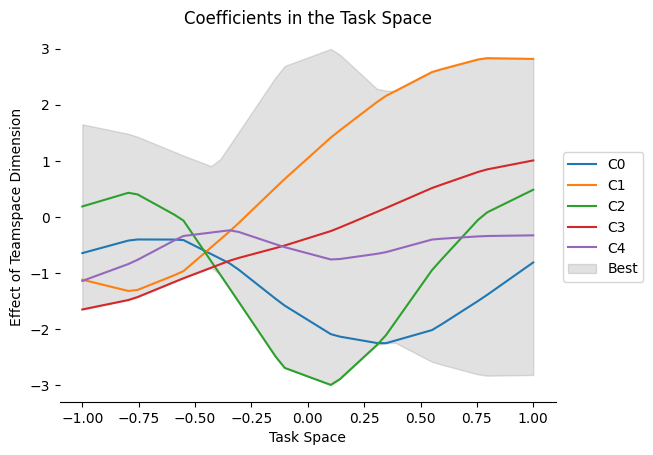

In [2]:
n_teamspace_dims = 5
n_taskspace_dims = 1
true_gp_length_scale = .5
dtype = np.float64

def get_taskspace_measurer(n_taskspace_dims=3, gp_length_scale=.5, n_teamspace_dims=3, n=10):
    ranges = [np.linspace(-1, 1, n) for _ in range(n_taskspace_dims)]
    task_space = np.meshgrid(*ranges)
    task_space_flat = np.array([task_space[i].flatten() for i in range(n_taskspace_dims)]).T

    def sample_gp():
        mean_func = pm.gp.mean.Zero()
        cov_func = pm.gp.cov.ExpQuad(input_dim=n_taskspace_dims, ls=gp_length_scale)
        f_true_flat = np.random.multivariate_normal(
            mean_func(task_space_flat).eval(), 
            cov_func(task_space_flat).eval() + 1e-8 * np.eye(n**n_taskspace_dims), 1)
        f_true = f_true_flat.reshape(*[n]*n_taskspace_dims)
        return f_true

    fs = [sample_gp() for _ in range(n_teamspace_dims)]
    b = 0
    
    def measure_task(T):
        Cs = np.array([interpn(ranges, f, T) for f in fs]).flatten()
        return Cs, b
    
    return measure_task

measure_task = get_taskspace_measurer(n_taskspace_dims, true_gp_length_scale, n_teamspace_dims)

ts = np.linspace(-1, 1, 50)
ts_samples = pd.DataFrame(index=ts, data=[measure_task([t])[0] for t in ts])
for col in ts_samples:
    plt.plot(ts_samples.index, ts_samples[col], label="C%i" % col)

plt.title("Coefficients in the Task Space")
plt.xlabel("Task Space")
plt.ylabel("Effect of Teamspace Dimension")

best = ts_samples.abs().max(axis=1)
plt.fill_between(best.index, best, -best, color='dimgrey', alpha=.2, zorder=-100, label="Best")
plt.legend(loc='center left', bbox_to_anchor=(1, .5))
print("True 'Performance': %.02f" % np.mean(best))

### Define Ground Truth and Measurement Functions

In [3]:
def ground_truth(X, T, measure_task):
    Cs, b = measure_task(T)
    z = np.dot(Cs, X) + b
    return z

def measure(X, T, measure_task):
    sigma = .5
    z_measured = ground_truth(X, T, measure_task) + np.random.normal(loc=0, scale=sigma)
    return z_measured.astype(dtype)

measure(X=np.random.uniform(-1, 1, size=n_teamspace_dims), T=np.random.uniform(-1, 1, size=n_taskspace_dims), measure_task=measure_task)

0.20547695732408927

### Define Alternative Models

In [4]:
def build_model(task_samples, team_samples, z_observations, gp_length_scale=.4):
    n_samples = task_samples.shape[0]

    with pm.Model() as taskspace_hierarchical_model:
        cov_func = pm.gp.cov.ExpQuad(n_taskspace_dims, ls=gp_length_scale)
        GPs = [pm.gp.Latent(cov_func=cov_func) for i in range(n_teamspace_dims)]
        Cs = pm.Deterministic("Cs", pm.math.stack(
             [gpi.prior("C%i" % i, X=task_samples, shape=n_samples) for i, gpi in enumerate(GPs)]).T)
        b = pm.Normal("b", mu=dtype(0), sd=dtype(5))
        noise = pm.Gamma("noise", alpha=dtype(2), beta=dtype(1))
        z = pm.Deterministic("z", pm.math.sum(Cs * team_samples, axis=1) + b)
        z_measured = pm.Normal("z_measured", mu=z, sd=noise, observed=z_observations)

    return taskspace_hierarchical_model, (GPs, b)

n_samples = 10
task_samples = np.random.uniform(-1, 1, size=(n_samples, n_taskspace_dims)).astype(dtype)
team_samples = np.random.uniform(-1, 1, size=(n_samples, n_teamspace_dims)).astype(dtype)
z_observations = np.array([measure(Xi, Ti, measure_task) for Xi, Ti in zip(team_samples, task_samples)]).astype(dtype)

taskspace_hierarchical_model, elements = build_model(task_samples, team_samples, z_observations)

pm.model_to_graphviz(taskspace_hierarchical_model)

with taskspace_hierarchical_model:
    trace = pm.sample(draws=500, tune=2000, progressbar=True)

Sampling 4 chains, 8 divergences: 100%|█████████████████████████████████████| 10000/10000 [03:56<00:00, 42.32draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


### Visualize Task Space

C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


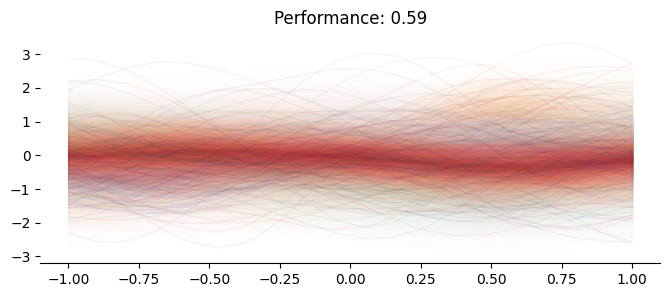

In [5]:
def visualize_task_space(taskspace_hierarchical_model, elements, trace, ax, plot_t=[np.linspace(-1, 1, 20), np.linspace(-1, 1, 20)], n_predictions=500, draw=True):
    GPs, b = elements
    task_space = np.meshgrid(*plot_t)
    task_space_flat = np.array([task_space_dim.flatten() for task_space_dim in task_space]).T
    n_samples = len(task_space_flat)
    
    with taskspace_hierarchical_model:
        Cs_plot = pm.Deterministic("Cs_plot", pm.math.stack(
             [gpi.conditional("C%i_plot" % i, Xnew=task_space_flat, shape=n_samples) for i, gpi in enumerate(GPs)]).T)
        C_functions = pm.sample_posterior_predictive(trace, var_names=["Cs_plot"], samples=n_predictions, progressbar=False)
    
    performance = np.abs(C_functions['Cs_plot'].mean(axis=0)).max(axis=1).mean()

    if not draw:
        return performance
    
    if (np.array(task_space[0].shape) != 1).sum() == 2:
        import plotly.graph_objects as go
        means = C_functions['Cs_plot'].mean(axis=0)
        cmap = plt.get_cmap("tab10")
        colorscale = [[0, 'rgb' + str(cmap(1)[0:3])], [1, 'rgb' + str(cmap(2)[0:3])]]

        fig = go.Figure(data=[go.Surface(z=means[:, Ci].reshape(20, 20), 
                                         surfacecolor=np.ones(shape=(40, 40)) * Ci, 
                                         colorscale=colorscale, cmin=0, cmax=2) 
                              for Ci in range(C_functions['Cs_plot'].shape[2])])
        fig.show()
        
    elif (np.array(task_space[0].shape) != 1).sum() == 1:
        palettes = ['Blues', 'Oranges', 'Greens', 'Purples', 'Reds']
        for Ci in range(C_functions['Cs_plot'].shape[2]):
            plot_gp_dist(ax, C_functions['Cs_plot'][:, :, Ci], task_space[0], palette=palettes[Ci], fill_alpha=.05, samples_alpha=.05)
        plt.title("Performance: %.02f" % performance)

    return performance
    
plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 1, 1)
performance = visualize_task_space(taskspace_hierarchical_model, elements, trace, plot_t=[np.linspace(-1, 1, 20)], ax=ax)

### Predict Coefficients and Results for Candidate Task and Team Locations

In [6]:
import numpy as np
import pymc3 as pm
import uuid

def predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs, n_predictions=1000, chunk_size=100):
    GPs, b = elements
    n_samples = new_Ts.shape[0]
    n_teams = candidate_Xs.shape[0]

    with taskspace_hierarchical_model:
        unique_id = str(uuid.uuid4())  # Generate a unique ID
        Cs_predict = pm.Deterministic("Cs_predict_" + unique_id, pm.math.stack(
            [gpi.conditional(f"C{i}_predict_" + unique_id, Xnew=new_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]))

        predictions = pm.sample_posterior_predictive(trace, var_names=["Cs_predict_" + unique_id], samples=n_predictions, progressbar=True)

    Cs_predict_samples = predictions["Cs_predict_" + unique_id]  # Shape (n_predictions, n_samples, n_teamspace_dims)

    # Validate shapes
    print("Cs_predict_samples shape:", Cs_predict_samples.shape)
    if len(Cs_predict_samples.shape) == 4:
        Cs_predict_samples = Cs_predict_samples[:, 0, :, :]

    candidate_Xs_expanded = np.expand_dims(candidate_Xs, axis=0)  # Shape (1, n_teams, n_teamspace_dims)
    candidate_Xs_expanded = np.tile(candidate_Xs_expanded, (chunk_size, 1, 1))  # Shape (chunk_size, n_teams, n_teamspace_dims)

    # Debugging info: print shapes for validation
    print("Cs_predict_samples shape (after adjustment):", Cs_predict_samples.shape)
    print("candidate_Xs_expanded shape:", candidate_Xs_expanded.shape)

    # Perform matrix multiplication for each sample
    z_predict = np.zeros((n_predictions, n_teams, n_samples))
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        candidate_Xs_chunk = candidate_Xs_expanded[:chunk_size_actual]
        z_predict_chunk = np.einsum('ijk,ikl->ijl', candidate_Xs_chunk, np.swapaxes(Cs_predict_samples[i:end], 1, 2))  # Shape (chunk_size, n_teams, n_samples)
        print(f"z_predict_chunk shape ({i}-{end}):", z_predict_chunk.shape)
        z_predict[i:end] = z_predict_chunk

    # Process each chunk of bias 'b'
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        b_expanded_chunk = np.expand_dims(trace['b'][i:end], axis=-1)  # Shape (chunk_size_actual, n_samples, 1)
        b_expanded_chunk = np.expand_dims(b_expanded_chunk, axis=1)  # Shape (chunk_size_actual, 1, n_samples, 1)
        b_tiled_chunk = np.tile(b_expanded_chunk, (1, n_teams, 1, 1))  # Shape (chunk_size_actual, n_teams, n_samples, 1)
        b_tiled_chunk = np.squeeze(b_tiled_chunk, axis=-1)  # Shape (chunk_size_actual, n_teams, n_samples)
        
        # Adjust shape of b_tiled_chunk to match z_predict
        b_tiled_chunk = b_tiled_chunk[..., :z_predict.shape[-1]]  # Slice adjustment
        print(f"b_expanded_chunk ({i}-{end}):", b_expanded_chunk.shape)  # Validate shape
        print(f"b_tiled_chunk ({i}-{end}):", b_tiled_chunk.shape)  # Validate shape
        
        z_predict[i:end] += b_tiled_chunk

    # Debugging info: print final shape
    print("z_predict shape:", z_predict.shape)

    predictions['z_predict'] = z_predict  # Shape (n_predictions, n_teams, n_samples)

    return predictions

# Example usage
n_tasks = 2  # Reduce data size for faster debugging
n_teams = 3  # Reduce data size for faster debugging
n_teamspace_dims = 2  # Reduce data size for faster debugging
dtype = np.float64
n_predictions = 1000  # Reduce data size for faster debugging

# Build a simple PyMC3 model to get an effective trace
with pm.Model() as model:
    X = pm.Normal("X", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    Y = pm.Normal("Y", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    b = pm.Normal("b", mu=0, sigma=1, shape=n_predictions)
    trace = pm.sample(800, tune=800, cores=1)  # Reduce sample size for faster debugging

# Use actual elements from the model
class DummyGP:
    def conditional(self, name, Xnew, shape):
        return pm.Normal(name, mu=0, sigma=1, shape=(shape, n_teamspace_dims))

taskspace_hierarchical_model = model
elements = ([DummyGP() for _ in range(n_teamspace_dims)], trace['b'])

new_Ts = np.linspace(-1, 1, n_tasks).astype(dtype)[:, None]
candidate_Xs = np.random.uniform(-1, 1, size=(n_teams, n_teamspace_dims)).astype(dtype)

predictions = predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs)
for k, v in predictions.items():
    print(k, v.shape)


Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████| 1600/1600 [02:39<00:00, 10.06it/s]
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 872.39it/s]


Cs_predict_samples shape: (1000, 2, 2, 2)
Cs_predict_samples shape (after adjustment): (1000, 2, 2)
candidate_Xs_expanded shape: (100, 3, 2)
z_predict_chunk shape (0-100): (100, 3, 2)
z_predict_chunk shape (100-200): (100, 3, 2)
z_predict_chunk shape (200-300): (100, 3, 2)
z_predict_chunk shape (300-400): (100, 3, 2)
z_predict_chunk shape (400-500): (100, 3, 2)
z_predict_chunk shape (500-600): (100, 3, 2)
z_predict_chunk shape (600-700): (100, 3, 2)
z_predict_chunk shape (700-800): (100, 3, 2)
z_predict_chunk shape (800-900): (100, 3, 2)
z_predict_chunk shape (900-1000): (100, 3, 2)
b_expanded_chunk (0-100): (100, 1, 1000, 1)
b_tiled_chunk (0-100): (100, 3, 2)
b_expanded_chunk (100-200): (100, 1, 1000, 1)
b_tiled_chunk (100-200): (100, 3, 2)
b_expanded_chunk (200-300): (100, 1, 1000, 1)
b_tiled_chunk (200-300): (100, 3, 2)
b_expanded_chunk (300-400): (100, 1, 1000, 1)
b_tiled_chunk (300-400): (100, 3, 2)
b_expanded_chunk (400-500): (100, 1, 1000, 1)
b_tiled_chunk (400-500): (100, 3, 2)

In [7]:
import numpy as np
import pymc3 as pm
import uuid

def predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs, n_predictions=1000, chunk_size=100):
    GPs, b = elements
    n_samples = new_Ts.shape[0]
    n_teams = candidate_Xs.shape[0]

    with taskspace_hierarchical_model:
        unique_id = str(uuid.uuid4())  # Generate a unique ID
        Cs_predict = pm.Deterministic("Cs_predict_" + unique_id, pm.math.stack(
            [gpi.conditional(f"C{i}_predict_" + unique_id, Xnew=new_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]))

        predictions = pm.sample_posterior_predictive(trace, var_names=["Cs_predict_" + unique_id], samples=n_predictions, progressbar=True)

    Cs_predict_samples = predictions["Cs_predict_" + unique_id]  # Shape (n_predictions, n_samples, n_teamspace_dims)

    # Validate shapes
    print("Cs_predict_samples shape:", Cs_predict_samples.shape)
    if len(Cs_predict_samples.shape) == 4:
        Cs_predict_samples = Cs_predict_samples[:, 0, :, :]

    candidate_Xs_expanded = np.expand_dims(candidate_Xs, axis=0)  # Shape (1, n_teams, n_teamspace_dims)
    candidate_Xs_expanded = np.tile(candidate_Xs_expanded, (chunk_size, 1, 1))  # Shape (chunk_size, n_teams, n_teamspace_dims)

    # Debugging info: print shapes for validation
    print("Cs_predict_samples shape (after adjustment):", Cs_predict_samples.shape)
    print("candidate_Xs_expanded shape:", candidate_Xs_expanded.shape)

    # Perform matrix multiplication for each sample
    z_predict = np.zeros((n_predictions, n_teams, n_samples))
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        candidate_Xs_chunk = candidate_Xs_expanded[:chunk_size_actual]
        z_predict_chunk = np.einsum('ijk,ikl->ijl', candidate_Xs_chunk, np.swapaxes(Cs_predict_samples[i:end], 1, 2))  # Shape (chunk_size, n_teams, n_samples)
        print(f"z_predict_chunk shape ({i}-{end}):", z_predict_chunk.shape)
        z_predict[i:end] = z_predict_chunk

    # Process each chunk of bias 'b'
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        b_expanded_chunk = np.expand_dims(trace['b'][i:end], axis=-1)  # Shape (chunk_size_actual, n_samples, 1)
        b_expanded_chunk = np.expand_dims(b_expanded_chunk, axis=1)  # Shape (chunk_size_actual, 1, n_samples, 1)
        b_tiled_chunk = np.tile(b_expanded_chunk, (1, n_teams, 1, 1))  # Shape (chunk_size_actual, n_teams, n_samples, 1)
        b_tiled_chunk = np.squeeze(b_tiled_chunk, axis=-1)  # Shape (chunk_size_actual, n_teams, n_samples)
        
        # Adjust shape of b_tiled_chunk to match z_predict
        b_tiled_chunk = b_tiled_chunk[..., :z_predict.shape[-1]]  # Slice adjustment
        print(f"b_expanded_chunk ({i}-{end}):", b_expanded_chunk.shape)  # Validate shape
        print(f"b_tiled_chunk ({i}-{end}):", b_tiled_chunk.shape)  # Validate shape
        
        z_predict[i:end] += b_tiled_chunk

    # Debugging info: print final shape
    print("z_predict shape:", z_predict.shape)

    predictions['z_predict'] = z_predict  # Shape (n_predictions, n_teams, n_samples)

    return predictions

# Example usage
n_tasks = 25  # Reduce data size for faster debugging
n_teams = 30  # Reduce data size for faster debugging
n_teamspace_dims = 2  # Reduce data size for faster debugging
dtype = np.float64
n_predictions = 1000  # Reduce data size for faster debugging

# Build a simple PyMC3 model to get an effective trace
with pm.Model() as model:
    X = pm.Normal("X", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    Y = pm.Normal("Y", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    b = pm.Normal("b", mu=0, sigma=1, shape=n_predictions)
    trace = pm.sample(2000, tune=1000, cores=4)  # Reduce sample size for faster debugging

# Use actual elements from the model
class DummyGP:
    def conditional(self, name, Xnew, shape):
        return pm.Normal(name, mu=0, sigma=1, shape=(shape, n_teamspace_dims))

taskspace_hierarchical_model = model
elements = ([DummyGP() for _ in range(n_teamspace_dims)], trace['b'])

new_Ts = np.linspace(-1, 1, n_tasks).astype(dtype)[:, None]
candidate_Xs = np.random.uniform(-1, 1, size=(n_teams, n_teamspace_dims)).astype(dtype)

predictions = predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs)
for k, v in predictions.items():
    print(k, v.shape)


Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 12000/12000 [11:51<00:00, 16.86draws/s]
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 896.32it/s]


Cs_predict_samples shape: (1000, 2, 25, 2)
Cs_predict_samples shape (after adjustment): (1000, 25, 2)
candidate_Xs_expanded shape: (100, 30, 2)
z_predict_chunk shape (0-100): (100, 30, 25)
z_predict_chunk shape (100-200): (100, 30, 25)
z_predict_chunk shape (200-300): (100, 30, 25)
z_predict_chunk shape (300-400): (100, 30, 25)
z_predict_chunk shape (400-500): (100, 30, 25)
z_predict_chunk shape (500-600): (100, 30, 25)
z_predict_chunk shape (600-700): (100, 30, 25)
z_predict_chunk shape (700-800): (100, 30, 25)
z_predict_chunk shape (800-900): (100, 30, 25)
z_predict_chunk shape (900-1000): (100, 30, 25)
b_expanded_chunk (0-100): (100, 1, 1000, 1)
b_tiled_chunk (0-100): (100, 30, 25)
b_expanded_chunk (100-200): (100, 1, 1000, 1)
b_tiled_chunk (100-200): (100, 30, 25)
b_expanded_chunk (200-300): (100, 1, 1000, 1)
b_tiled_chunk (200-300): (100, 30, 25)
b_expanded_chunk (300-400): (100, 1, 1000, 1)
b_tiled_chunk (300-400): (100, 30, 25)
b_expanded_chunk (400-500): (100, 1, 1000, 1)
b_til

### Define Acquisition Functions

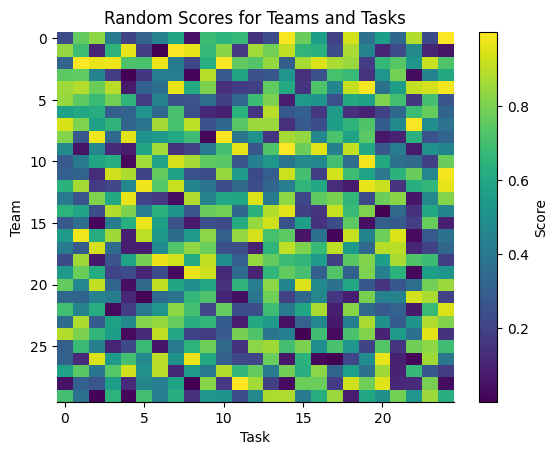

Selected Task: [0.16666667]
Selected Team: [-0.46232677 -0.70196281]


In [8]:
def aq_random(predictions):
    scores = np.random.random(size=predictions['z_predict'].shape[1:])
    return scores

def choose_max(scores, new_Ts, candidate_Xs):
    team_index, task_index = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
    return team_index, task_index

# Generate random scores and visualize
scores = aq_random(predictions)
plt.imshow(scores, aspect='auto')
plt.xlabel('Task')
plt.ylabel('Team')
plt.colorbar(label='Score')
plt.title('Random Scores for Teams and Tasks')
plt.show()

# Choose the team and task with the highest score
team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
print("Selected Task:", new_Ts[task_index])
print("Selected Team:", candidate_Xs[team_index])


### Uncertainty Sampling (Maximum Variance)

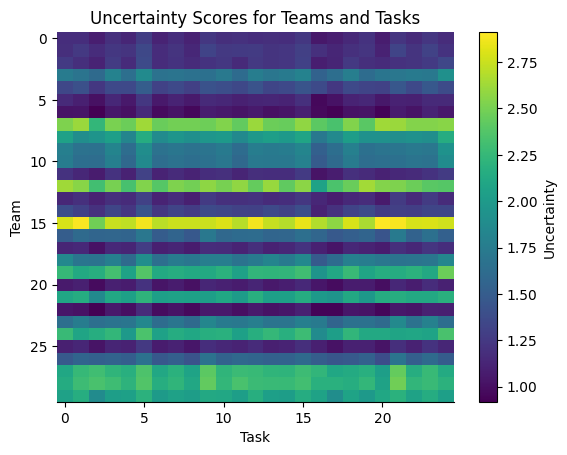

Selected Task: [0.66666667]
Selected Team: [ 0.92214596 -0.94738718]


In [9]:
def aq_varmax(predictions):
    # Calculate uncertainty (variance) of predictions
    uncertainties = predictions['z_predict'].var(axis=0)
    return uncertainties

# Calculate uncertainty scores
scores = aq_varmax(predictions)

# Visualize scores
plt.imshow(scores, aspect='auto')
plt.xlabel('Task')
plt.ylabel('Team')
plt.colorbar(label='Uncertainty')
plt.title('Uncertainty Scores for Teams and Tasks')
plt.show()

# Choose the team and task with the highest uncertainty score
team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
print("Selected Task:", new_Ts[task_index])
print("Selected Team:", candidate_Xs[team_index])

### Improved Probability (PI)

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1315.56it/s]


Cs_predict_samples shape: (1000, 2, 5, 2)
Cs_predict_samples shape (after adjustment): (1000, 5, 2)
candidate_Xs_expanded shape: (100, 5, 2)
z_predict_chunk shape (0-100): (100, 5, 5)
z_predict_chunk shape (100-200): (100, 5, 5)
z_predict_chunk shape (200-300): (100, 5, 5)
z_predict_chunk shape (300-400): (100, 5, 5)
z_predict_chunk shape (400-500): (100, 5, 5)
z_predict_chunk shape (500-600): (100, 5, 5)
z_predict_chunk shape (600-700): (100, 5, 5)
z_predict_chunk shape (700-800): (100, 5, 5)
z_predict_chunk shape (800-900): (100, 5, 5)
z_predict_chunk shape (900-1000): (100, 5, 5)
b_expanded_chunk (0-100): (100, 1, 50, 1)
b_tiled_chunk (0-100): (100, 5, 5)
b_expanded_chunk (100-200): (100, 1, 50, 1)
b_tiled_chunk (100-200): (100, 5, 5)
b_expanded_chunk (200-300): (100, 1, 50, 1)
b_tiled_chunk (200-300): (100, 5, 5)
b_expanded_chunk (300-400): (100, 1, 50, 1)
b_tiled_chunk (300-400): (100, 5, 5)
z_predict shape: (1000, 5, 5)
Cs_predict_9e523279-8b2c-4791-ab52-efcb9cc2f7c2 (1000, 2, 5,

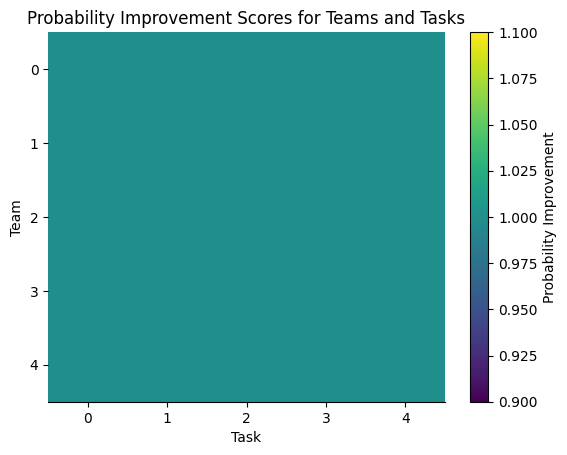

Selected Task: [-1.]
Selected Team: [-0.71576688 -0.06493239]


In [10]:
import numpy as np
import pymc3 as pm
import uuid
import matplotlib.pyplot as plt

def predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs, n_predictions=1000, chunk_size=100):
    GPs, b = elements
    n_samples = new_Ts.shape[0]
    n_teams = candidate_Xs.shape[0]

    with taskspace_hierarchical_model:
        unique_id = str(uuid.uuid4())  # Generate a unique ID
        Cs_predict_name = "Cs_predict_" + unique_id
        Cs_predict = pm.Deterministic(Cs_predict_name, pm.math.stack(
            [gpi.conditional(f"C{i}_predict_" + unique_id, Xnew=new_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]))

        predictions = pm.sample_posterior_predictive(trace, var_names=[Cs_predict_name], samples=n_predictions, progressbar=True)

    Cs_predict_samples = predictions[Cs_predict_name]  # Shape (n_predictions, n_samples, n_teamspace_dims)

    # Validate shape
    print("Cs_predict_samples shape:", Cs_predict_samples.shape)
    if len(Cs_predict_samples.shape) == 4:
        Cs_predict_samples = Cs_predict_samples[:, 0, :, :]

    candidate_Xs_expanded = np.expand_dims(candidate_Xs, axis=0)  # Shape (1, n_teams, n_teamspace_dims)
    candidate_Xs_expanded = np.tile(candidate_Xs_expanded, (chunk_size, 1, 1))  # Shape (chunk_size, n_teams, n_teamspace_dims)

    # Debugging info: print shapes for validation
    print("Cs_predict_samples shape (after adjustment):", Cs_predict_samples.shape)
    print("candidate_Xs_expanded shape:", candidate_Xs_expanded.shape)

    # Matrix multiplication for each sample
    z_predict = np.zeros((n_predictions, n_teams, n_samples))
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        candidate_Xs_chunk = candidate_Xs_expanded[:chunk_size_actual]
        z_predict_chunk = np.einsum('ijk,ikl->ijl', candidate_Xs_chunk, np.swapaxes(Cs_predict_samples[i:end], 1, 2))  # Shape (chunk_size, n_teams, n_samples)
        print(f"z_predict_chunk shape ({i}-{end}):", z_predict_chunk.shape)
        z_predict[i:end] = z_predict_chunk

    # Handling bias 'b' for each chunk
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        if chunk_size_actual == 0:
            continue  # Skip empty chunks
        b_expanded_chunk = np.expand_dims(trace['b'][i:end], axis=-1)  # Shape (chunk_size_actual, n_samples, 1)
        b_expanded_chunk = np.expand_dims(b_expanded_chunk, axis=1)  # Shape (chunk_size_actual, 1, n_samples, 1)
        if b_expanded_chunk.size == 0:  # If b_expanded_chunk is empty, move to next loop iteration
            continue
        b_tiled_chunk = np.tile(b_expanded_chunk, (1, n_teams, 1, 1))  # Shape (chunk_size_actual, n_teams, n_samples, 1)
        b_tiled_chunk = np.squeeze(b_tiled_chunk, axis=-1)  # Shape (chunk_size_actual, n_teams, n_samples)
        
        # Adjust b_tiled_chunk shape to match z_predict
        b_tiled_chunk = b_tiled_chunk[:, :, :z_predict.shape[2]]  # Slice adjustment
        print(f"b_expanded_chunk ({i}-{end}):", b_expanded_chunk.shape)  # Validate shape
        print(f"b_tiled_chunk ({i}-{end}):", b_tiled_chunk.shape)  # Validate shape
        
        z_predict[i:end] += b_tiled_chunk

    # Debugging info: print final shape
    print("z_predict shape:", z_predict.shape)

    predictions['z_predict'] = z_predict  # Shape (n_predictions, n_teams, n_samples)

    return predictions, Cs_predict_name

# Hypothetical smoothing function to process prediction results
def linear_smooth(predictions):
    # Specific implementation of smoothing logic would go here
    return predictions['z_predict']  # Example: returning raw prediction results

def aq_PI(predictions, Cs_predict_name, n_teams):
    smooth = linear_smooth(predictions)
    max_C = smooth.max(axis=0)
    
    # Calculate Cvals and best_Cvals
    Cvals = predictions[Cs_predict_name].mean(axis=0)
    best_Cvals = np.abs(Cvals).max(axis=0)
    best_Cvals = np.tile(best_Cvals, (predictions[Cs_predict_name].shape[0], 1, 1))
    best_Cvals = np.moveaxis(best_Cvals, [0], [2])

    epsilon = 0.0001
    # Adjust best_Cvals shape to match max_C shape
    best_Cvals = best_Cvals[:max_C.shape[0], :, :max_C.shape[1]]
    best_Cvals = best_Cvals.transpose((1, 0, 2))  # Ensure shape matches
    return (max_C > best_Cvals + epsilon).mean(axis=0)

# Example usage
n_tasks = 5  # Reduced for faster debugging
n_teams = 5  # Reduced for faster debugging
n_teamspace_dims = 2  # Reduced for faster debugging
dtype = np.float64
n_predictions = 50  # Reduced for faster debugging

# Build a simple PyMC3 model to get an effective trace
with pm.Model() as model:
    X = pm.Normal("X", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    Y = pm.Normal("Y", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    b = pm.Normal("b", mu=0, sigma=1, shape=n_predictions)
    trace = pm.sample(200, tune=100, cores=1)  # Reduced sample size for faster debugging

# Use actual elements from the model
class DummyGP:
    def conditional(self, name, Xnew, shape):
        return pm.Normal(name, mu=0, sigma=1, shape=(shape, n_teamspace_dims))

taskspace_hierarchical_model = model
elements = ([DummyGP() for _ in range(n_teamspace_dims)], trace['b'])

new_Ts = np.linspace(-1, 1, n_tasks).astype(dtype)[:, None]
candidate_Xs = np.random.uniform(-1, 1, size=(n_teams, n_teamspace_dims)).astype(dtype)

predictions, Cs_predict_name = predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs)
for k, v in predictions.items():
    print(k, v.shape)

# Use aq_PI function to calculate uncertainty scores
scores = aq_PI(predictions, Cs_predict_name, n_teams)

# Visualize uncertainty scores
plt.imshow(scores, aspect='auto')
plt.xlabel('Task')
plt.ylabel('Team')
plt.colorbar(label='Probability Improvement')
plt.title('Probability Improvement Scores for Teams and Tasks')
plt.show()

# Select the team and task with the highest score
team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
print("Selected Task:", new_Ts[task_index])
print("Selected Team:", candidate_Xs[team_index])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, Y, X]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 12000/12000 [07:58<00:00, 25.10draws/s]
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1073.57it/s]


Cs_predict_samples shape: (1000, 2, 25, 2)
Cs_predict_samples shape (after adjustment): (1000, 25, 2)
candidate_Xs_expanded shape: (100, 30, 2)
z_predict_chunk shape (0-100): (100, 30, 25)
z_predict_chunk shape (100-200): (100, 30, 25)
z_predict_chunk shape (200-300): (100, 30, 25)
z_predict_chunk shape (300-400): (100, 30, 25)
z_predict_chunk shape (400-500): (100, 30, 25)
z_predict_chunk shape (500-600): (100, 30, 25)
z_predict_chunk shape (600-700): (100, 30, 25)
z_predict_chunk shape (700-800): (100, 30, 25)
z_predict_chunk shape (800-900): (100, 30, 25)
z_predict_chunk shape (900-1000): (100, 30, 25)
b_expanded_chunk (0-100): (100, 1, 1000, 1)
b_tiled_chunk (0-100): (100, 30, 25)
b_expanded_chunk (100-200): (100, 1, 1000, 1)
b_tiled_chunk (100-200): (100, 30, 25)
b_expanded_chunk (200-300): (100, 1, 1000, 1)
b_tiled_chunk (200-300): (100, 30, 25)
b_expanded_chunk (300-400): (100, 1, 1000, 1)
b_tiled_chunk (300-400): (100, 30, 25)
b_expanded_chunk (400-500): (100, 1, 1000, 1)
b_til

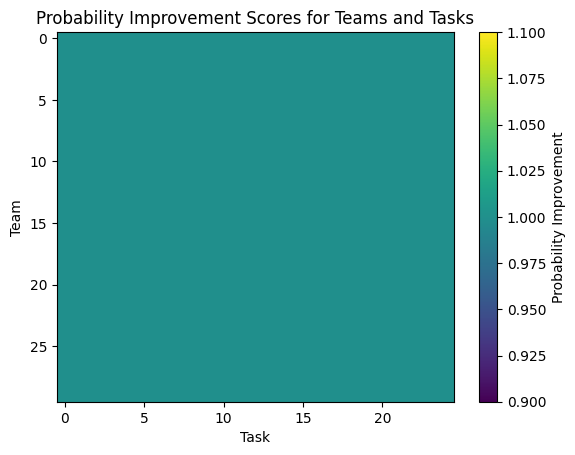

Selected Task: [-1.]
Selected Team: [0.17047754 0.23649178]


In [24]:
import numpy as np
import pymc3 as pm
import uuid
import matplotlib.pyplot as plt

def predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs, n_predictions=1000, chunk_size=100):
    GPs, b = elements
    n_samples = new_Ts.shape[0]
    n_teams = candidate_Xs.shape[0]

    with taskspace_hierarchical_model:
        unique_id = str(uuid.uuid4())  # Generate a unique ID
        Cs_predict_name = "Cs_predict_" + unique_id
        Cs_predict = pm.Deterministic(Cs_predict_name, pm.math.stack(
            [gpi.conditional(f"C{i}_predict_" + unique_id, Xnew=new_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]))

        predictions = pm.sample_posterior_predictive(trace, var_names=[Cs_predict_name], samples=n_predictions, progressbar=True)

    Cs_predict_samples = predictions[Cs_predict_name]  # Shape (n_predictions, n_samples, n_teamspace_dims)

    # Validate shape
    print("Cs_predict_samples shape:", Cs_predict_samples.shape)
    if len(Cs_predict_samples.shape) == 4:
        Cs_predict_samples = Cs_predict_samples[:, 0, :, :]

    candidate_Xs_expanded = np.expand_dims(candidate_Xs, axis=0)  # Shape (1, n_teams, n_teamspace_dims)
    candidate_Xs_expanded = np.tile(candidate_Xs_expanded, (chunk_size, 1, 1))  # Shape (chunk_size, n_teams, n_teamspace_dims)

    # Debugging info: print shapes for validation
    print("Cs_predict_samples shape (after adjustment):", Cs_predict_samples.shape)
    print("candidate_Xs_expanded shape:", candidate_Xs_expanded.shape)

    # Matrix multiplication for each sample
    z_predict = np.zeros((n_predictions, n_teams, n_samples))
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        candidate_Xs_chunk = candidate_Xs_expanded[:chunk_size_actual]
        z_predict_chunk = np.einsum('ijk,ikl->ijl', candidate_Xs_chunk, np.swapaxes(Cs_predict_samples[i:end], 1, 2))  # Shape (chunk_size, n_teams, n_samples)
        print(f"z_predict_chunk shape ({i}-{end}):", z_predict_chunk.shape)
        z_predict[i:end] = z_predict_chunk

    # Handling bias 'b' for each chunk
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        if chunk_size_actual == 0:
            continue  # Skip empty chunks
        b_expanded_chunk = np.expand_dims(trace['b'][i:end], axis=-1)  # Shape (chunk_size_actual, n_samples, 1)
        b_expanded_chunk = np.expand_dims(b_expanded_chunk, axis=1)  # Shape (chunk_size_actual, 1, n_samples, 1)
        if b_expanded_chunk.size == 0:  # If b_expanded_chunk is empty, move to next loop iteration
            continue
        b_tiled_chunk = np.tile(b_expanded_chunk, (1, n_teams, 1, 1))  # Shape (chunk_size_actual, n_teams, n_samples, 1)
        b_tiled_chunk = np.squeeze(b_tiled_chunk, axis=-1)  # Shape (chunk_size_actual, n_teams, n_samples)
        
        # Adjust b_tiled_chunk shape to match z_predict
        b_tiled_chunk = b_tiled_chunk[:, :, :z_predict.shape[2]]  # Slice adjustment
        print(f"b_expanded_chunk ({i}-{end}):", b_expanded_chunk.shape)  # Validate shape
        print(f"b_tiled_chunk ({i}-{end}):", b_tiled_chunk.shape)  # Validate shape
        
        z_predict[i:end] += b_tiled_chunk

    # Debugging info: print final shape
    print("z_predict shape:", z_predict.shape)

    predictions['z_predict'] = z_predict  # Shape (n_predictions, n_teams, n_samples)

    return predictions, Cs_predict_name

# Hypothetical smoothing function to process prediction results
def linear_smooth(predictions):
    # Specific implementation of smoothing logic would go here
    return predictions['z_predict']  # Example: returning raw prediction results

def aq_PI(predictions, Cs_predict_name, n_teams):
    smooth = linear_smooth(predictions)
    max_C = smooth.max(axis=0)
    
    # Calculate Cvals and best_Cvals
    Cvals = predictions[Cs_predict_name].mean(axis=0)
    best_Cvals = np.abs(Cvals).max(axis=0)
    print("best_Cvals shape:", best_Cvals.shape)
    
    # Adjust best_Cvals shape to match max_C shape
    best_Cvals_expanded = best_Cvals.mean(axis=-1)  # Average over the third dimension
    best_Cvals_expanded = np.tile(best_Cvals_expanded, (n_teams, 1))  # Expand to shape (30, 25)
    
    print("max_C shape:", max_C.shape)
    print("best_Cvals_expanded shape:", best_Cvals_expanded.shape)
    
    epsilon = 0.0001
    scores_2d = (max_C > best_Cvals_expanded + epsilon).mean(axis=0, keepdims=True)  # Keep it 2D
    scores_2d = np.repeat(scores_2d, n_teams, axis=0)  # Repeat to increase team dimension
    print(scores_2d.shape)
    return scores_2d

# Example usage
n_tasks = 25  # Reduced for faster debugging
n_teams = 30  # Reduced for faster debugging
n_teamspace_dims = 2  # Reduced for faster debugging
dtype = np.float64
n_predictions = 1000  # Reduced for faster debugging

# Build a simple PyMC3 model to get an effective trace
with pm.Model() as model:
    X = pm.Normal("X", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    Y = pm.Normal("Y", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    b = pm.Normal("b", mu=0, sigma=1, shape=n_predictions)
    trace = pm.sample(2000, tune=1000, cores=4)  # Sample size

# Use actual elements from the model
class DummyGP:
    def conditional(self, name, Xnew, shape):
        return pm.Normal(name, mu=0, sigma=1, shape=(shape, n_teamspace_dims))

taskspace_hierarchical_model = model
elements = ([DummyGP() for _ in range(n_teamspace_dims)], trace['b'])

new_Ts = np.linspace(-1, 1, n_tasks).astype(dtype)[:, None]
candidate_Xs = np.random.uniform(-1, 1, size=(n_teams, n_teamspace_dims)).astype(dtype)

predictions, Cs_predict_name = predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs)
for k, v in predictions.items():
    print(k, v.shape)

# Use aq_PI function to calculate uncertainty scores
scores = aq_PI(predictions, Cs_predict_name, n_teams)

# Visualize uncertainty scores
plt.imshow(scores, aspect='auto')
plt.xlabel('Task')
plt.ylabel('Team')
plt.colorbar(label='Probability Improvement')
plt.title('Probability Improvement Scores for Teams and Tasks')
plt.show()

# Select the team and task with the highest score
def choose_max(scores, new_Ts, candidate_Xs):
    max_indices = np.unravel_index(np.argmax(scores), scores.shape)
    return max_indices

team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
print("Selected Task:", new_Ts[task_index])
print("Selected Team:", candidate_Xs[team_index])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, Y, X]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 12000/12000 [11:13<00:00, 17.82draws/s]
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 908.43it/s]


Cs_predict_samples shape: (1000, 2, 25, 2)
Cs_predict_samples shape (after adjustment): (1000, 25, 2)
candidate_Xs_expanded shape: (100, 30, 2)
z_predict_chunk shape (0-100): (100, 30, 25)
z_predict_chunk shape (100-200): (100, 30, 25)
z_predict_chunk shape (200-300): (100, 30, 25)
z_predict_chunk shape (300-400): (100, 30, 25)
z_predict_chunk shape (400-500): (100, 30, 25)
z_predict_chunk shape (500-600): (100, 30, 25)
z_predict_chunk shape (600-700): (100, 30, 25)
z_predict_chunk shape (700-800): (100, 30, 25)
z_predict_chunk shape (800-900): (100, 30, 25)
z_predict_chunk shape (900-1000): (100, 30, 25)
b_expanded_chunk (0-100): (100, 1, 1000, 1)
b_tiled_chunk (0-100): (100, 30, 25)
b_expanded_chunk (100-200): (100, 1, 1000, 1)
b_tiled_chunk (100-200): (100, 30, 25)
b_expanded_chunk (200-300): (100, 1, 1000, 1)
b_tiled_chunk (200-300): (100, 30, 25)
b_expanded_chunk (300-400): (100, 1, 1000, 1)
b_tiled_chunk (300-400): (100, 30, 25)
b_expanded_chunk (400-500): (100, 1, 1000, 1)
b_til

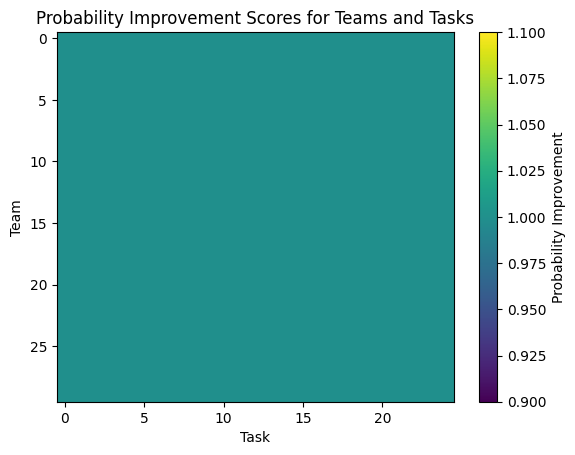

Selected Task: [-1.]
Selected Team: [-0.84445052 -0.53681816]


In [26]:
import numpy as np
import pymc3 as pm
import uuid
import matplotlib.pyplot as plt

def predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs, n_predictions=1000, chunk_size=100):
    GPs, b = elements
    n_samples = new_Ts.shape[0]
    n_teams = candidate_Xs.shape[0]

    with taskspace_hierarchical_model:
        unique_id = str(uuid.uuid4())  # Generate a unique ID
        Cs_predict_name = "Cs_predict_" + unique_id
        Cs_predict = pm.Deterministic(Cs_predict_name, pm.math.stack(
            [gpi.conditional(f"C{i}_predict_" + unique_id, Xnew=new_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]))

        predictions = pm.sample_posterior_predictive(trace, var_names=[Cs_predict_name], samples=n_predictions, progressbar=True)

    Cs_predict_samples = predictions[Cs_predict_name]  # Shape (n_predictions, n_samples, n_teamspace_dims)

    # Validate shape
    print("Cs_predict_samples shape:", Cs_predict_samples.shape)
    if len(Cs_predict_samples.shape) == 4:
        Cs_predict_samples = Cs_predict_samples[:, 0, :, :]

    candidate_Xs_expanded = np.expand_dims(candidate_Xs, axis=0)  # Shape (1, n_teams, n_teamspace_dims)
    candidate_Xs_expanded = np.tile(candidate_Xs_expanded, (chunk_size, 1, 1))  # Shape (chunk_size, n_teams, n_teamspace_dims)

    # Debugging info: print shapes for validation
    print("Cs_predict_samples shape (after adjustment):", Cs_predict_samples.shape)
    print("candidate_Xs_expanded shape:", candidate_Xs_expanded.shape)

    # Perform matrix multiplication for each sample
    z_predict = np.zeros((n_predictions, n_teams, n_samples))
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        candidate_Xs_chunk = candidate_Xs_expanded[:chunk_size_actual]
        z_predict_chunk = np.einsum('ijk,ikl->ijl', candidate_Xs_chunk, np.swapaxes(Cs_predict_samples[i:end], 1, 2))  # Shape (chunk_size, n_teams, n_samples)
        print(f"z_predict_chunk shape ({i}-{end}):", z_predict_chunk.shape)
        z_predict[i:end] = z_predict_chunk

    # Handle bias 'b' for each chunk
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        if chunk_size_actual == 0:
            continue  # Skip empty chunks
        b_expanded_chunk = np.expand_dims(trace['b'][i:end], axis=-1)  # Shape (chunk_size_actual, n_samples, 1)
        b_expanded_chunk = np.expand_dims(b_expanded_chunk, axis=1)  # Shape (chunk_size_actual, 1, n_samples, 1)
        if b_expanded_chunk.size == 0:  # If b_expanded_chunk is empty, move to next loop iteration
            continue
        b_tiled_chunk = np.tile(b_expanded_chunk, (1, n_teams, 1, 1))  # Shape (chunk_size_actual, n_teams, n_samples, 1)
        b_tiled_chunk = np.squeeze(b_tiled_chunk, axis=-1)  # Shape (chunk_size_actual, n_teams, n_samples)
        
        # Adjust b_tiled_chunk shape to match z_predict
        b_tiled_chunk = b_tiled_chunk[:, :, :z_predict.shape[2]]  # Slice adjustment
        print(f"b_expanded_chunk ({i}-{end}):", b_expanded_chunk.shape)  # Validate shape
        print(f"b_tiled_chunk ({i}-{end}):", b_tiled_chunk.shape)  # Validate shape
        
        z_predict[i:end] += b_tiled_chunk

    # Debugging info: print final shape
    print("z_predict shape:", z_predict.shape)

    predictions['z_predict'] = z_predict  # Shape (n_predictions, n_teams, n_samples)

    return predictions, Cs_predict_name

# Hypothetical smoothing function to process prediction results
def linear_smooth(predictions):
    # Specific implementation of smoothing logic would go here
    return predictions['z_predict']  # Example: returning raw prediction results

def aq_PI(predictions, Cs_predict_name, n_teams):
    smooth = linear_smooth(predictions)
    max_C = smooth.max(axis=0)
    
    # Calculate Cvals and best_Cvals
    Cvals = predictions[Cs_predict_name].mean(axis=0)
    best_Cvals = np.abs(Cvals).max(axis=0)
    print("best_Cvals shape:", best_Cvals.shape)
    
    # Adjust best_Cvals shape to match max_C shape
    best_Cvals_expanded = best_Cvals.mean(axis=-1)  # Average over the third dimension
    best_Cvals_expanded = np.tile(best_Cvals_expanded, (n_teams, 1))  # Expand to shape (30, 25)
    
    print("max_C shape:", max_C.shape)
    print("best_Cvals_expanded shape:", best_Cvals_expanded.shape)
    
    epsilon = 0.0001
    scores_2d = (max_C > best_Cvals_expanded + epsilon).mean(axis=0, keepdims=True)  # Keep it 2D
    scores_2d = np.repeat(scores_2d, n_teams, axis=0)  # Repeat to increase team dimension
    print(scores_2d.shape)
    return scores_2d

# Example usage
n_tasks = 25  # Reduced for faster debugging
n_teams = 30  # Reduced for faster debugging
n_teamspace_dims = 2  # Reduced for faster debugging
dtype = np.float64
n_predictions = 1000  # Reduced for faster debugging

# Build a simple PyMC3 model to get an effective trace
with pm.Model() as model:
    X = pm.Normal("X", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    Y = pm.Normal("Y", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    b = pm.Normal("b", mu=0, sigma=1, shape=n_predictions)
    trace = pm.sample(2000, tune=1000, cores=4)  # Sample size

# Use actual elements from the model
class DummyGP:
    def conditional(self, name, Xnew, shape):
        return pm.Normal(name, mu=0, sigma=1, shape=(shape, n_teamspace_dims))

taskspace_hierarchical_model = model
elements = ([DummyGP() for _ in range(n_teamspace_dims)], trace['b'])

new_Ts = np.linspace(-1, 1, n_tasks).astype(dtype)[:, None]
candidate_Xs = np.random.uniform(-1, 1, size=(n_teams, n_teamspace_dims)).astype(dtype)

predictions, Cs_predict_name = predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs)
for k, v in predictions.items():
    print(k, v.shape)

# Use aq_PI function to calculate uncertainty scores
scores = aq_PI(predictions, Cs_predict_name, n_teams)

# Visualize uncertainty scores
plt.imshow(scores, aspect='auto')
plt.xlabel('Task')
plt.ylabel('Team')
plt.colorbar(label='Probability Improvement')
plt.title('Probability Improvement Scores for Teams and Tasks')
plt.show()

# Select the team and task with the highest score
def choose_max(scores, new_Ts, candidate_Xs):
    max_indices = np.unravel_index(np.argmax(scores), scores.shape)
    return max_indices

team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
print("Selected Task:", new_Ts[task_index])
print("Selected Team:", candidate_Xs[team_index])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, Y, X]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 12000/12000 [07:41<00:00, 26.02draws/s]
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1088.23it/s]


Cs_predict_samples shape: (1000, 2, 25, 2)
Cs_predict_samples shape (after adjustment): (1000, 25, 2)
candidate_Xs_expanded shape: (100, 30, 2)
z_predict_chunk shape (0-100): (100, 30, 25)
z_predict_chunk shape (100-200): (100, 30, 25)
z_predict_chunk shape (200-300): (100, 30, 25)
z_predict_chunk shape (300-400): (100, 30, 25)
z_predict_chunk shape (400-500): (100, 30, 25)
z_predict_chunk shape (500-600): (100, 30, 25)
z_predict_chunk shape (600-700): (100, 30, 25)
z_predict_chunk shape (700-800): (100, 30, 25)
z_predict_chunk shape (800-900): (100, 30, 25)
z_predict_chunk shape (900-1000): (100, 30, 25)
b_expanded_chunk (0-100): (100, 1, 1000, 1)
b_tiled_chunk (0-100): (100, 30, 25)
b_expanded_chunk (100-200): (100, 1, 1000, 1)
b_tiled_chunk (100-200): (100, 30, 25)
b_expanded_chunk (200-300): (100, 1, 1000, 1)
b_tiled_chunk (200-300): (100, 30, 25)
b_expanded_chunk (300-400): (100, 1, 1000, 1)
b_tiled_chunk (300-400): (100, 30, 25)
b_expanded_chunk (400-500): (100, 1, 1000, 1)
b_til

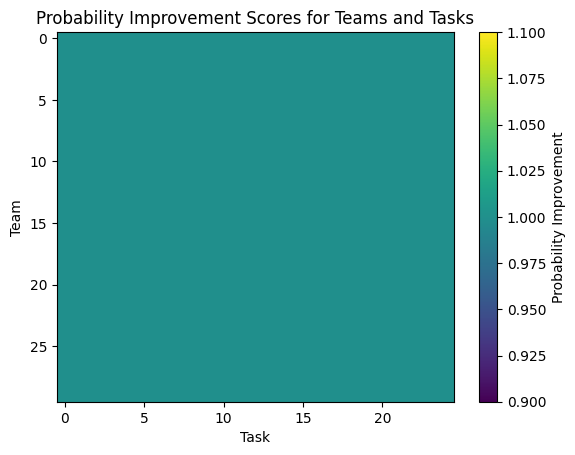

Selected Task: [-1.]
Selected Team: [-0.37339144 -0.63136611]


In [27]:
import numpy as np
import pymc3 as pm
import uuid
import matplotlib.pyplot as plt

def predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs, n_predictions=1000, chunk_size=100):
    GPs, b = elements
    n_samples = new_Ts.shape[0]
    n_teams = candidate_Xs.shape[0]

    with taskspace_hierarchical_model:
        unique_id = str(uuid.uuid4())  # Generate a unique ID
        Cs_predict_name = "Cs_predict_" + unique_id
        Cs_predict = pm.Deterministic(Cs_predict_name, pm.math.stack(
            [gpi.conditional(f"C{i}_predict_" + unique_id, Xnew=new_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]))

        predictions = pm.sample_posterior_predictive(trace, var_names=[Cs_predict_name], samples=n_predictions, progressbar=True)

    Cs_predict_samples = predictions[Cs_predict_name]  # Shape (n_predictions, n_samples, n_teamspace_dims)

    # Validate shape
    print("Cs_predict_samples shape:", Cs_predict_samples.shape)
    if len(Cs_predict_samples.shape) == 4:
        Cs_predict_samples = Cs_predict_samples[:, 0, :, :]

    candidate_Xs_expanded = np.expand_dims(candidate_Xs, axis=0)  # Shape (1, n_teams, n_teamspace_dims)
    candidate_Xs_expanded = np.tile(candidate_Xs_expanded, (chunk_size, 1, 1))  # Shape (chunk_size, n_teams, n_teamspace_dims)

    # Debugging info: print shapes for validation
    print("Cs_predict_samples shape (after adjustment):", Cs_predict_samples.shape)
    print("candidate_Xs_expanded shape:", candidate_Xs_expanded.shape)

    # Perform matrix multiplication for each sample
    z_predict = np.zeros((n_predictions, n_teams, n_samples))
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        candidate_Xs_chunk = candidate_Xs_expanded[:chunk_size_actual]
        z_predict_chunk = np.einsum('ijk,ikl->ijl', candidate_Xs_chunk, np.swapaxes(Cs_predict_samples[i:end], 1, 2))  # Shape (chunk_size, n_teams, n_samples)
        print(f"z_predict_chunk shape ({i}-{end}):", z_predict_chunk.shape)
        z_predict[i:end] = z_predict_chunk

    # Handle bias 'b' for each chunk
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        if chunk_size_actual == 0:
            continue  # Skip empty chunks
        b_expanded_chunk = np.expand_dims(trace['b'][i:end], axis=-1)  # Shape (chunk_size_actual, n_samples, 1)
        b_expanded_chunk = np.expand_dims(b_expanded_chunk, axis=1)  # Shape (chunk_size_actual, 1, n_samples, 1)
        if b_expanded_chunk.size == 0:  # If b_expanded_chunk is empty, move to next loop iteration
            continue
        b_tiled_chunk = np.tile(b_expanded_chunk, (1, n_teams, 1, 1))  # Shape (chunk_size_actual, n_teams, n_samples, 1)
        b_tiled_chunk = np.squeeze(b_tiled_chunk, axis=-1)  # Shape (chunk_size_actual, n_teams, n_samples)
        
        # Adjust b_tiled_chunk shape to match z_predict
        b_tiled_chunk = b_tiled_chunk[:, :, :z_predict.shape[2]]  # Slice adjustment
        print(f"b_expanded_chunk ({i}-{end}):", b_expanded_chunk.shape)  # Validate shape
        print(f"b_tiled_chunk ({i}-{end}):", b_tiled_chunk.shape)  # Validate shape
        
        z_predict[i:end] += b_tiled_chunk

    # Debugging info: print final shape
    print("z_predict shape:", z_predict.shape)
    print("z_predict:", z_predict[:5])  # Print first 5 predicted data for inspection

    predictions['z_predict'] = z_predict  # Shape (n_predictions, n_teams, n_samples)

    return predictions, Cs_predict_name

# Hypothetical smoothing function to process prediction results
def linear_smooth(predictions):
    smooth_output = predictions['z_predict']
    print("smooth_output:", smooth_output[:5])  # Print first 5 smoothed data for inspection
    return smooth_output  # Example: returning raw prediction results

def aq_PI(predictions, Cs_predict_name, n_teams):
    smooth = linear_smooth(predictions)
    max_C = smooth.max(axis=0)
    
    # Calculate Cvals and best_Cvals
    Cvals = predictions[Cs_predict_name].mean(axis=0)
    best_Cvals = np.abs(Cvals).max(axis=0)
    print("best_Cvals shape:", best_Cvals.shape)
    
    # Adjust best_Cvals shape to match max_C shape
    best_Cvals_expanded = best_Cvals.mean(axis=-1)  # Average over the third dimension
    best_Cvals_expanded = np.tile(best_Cvals_expanded, (n_teams, 1))  # Expand to shape (30, 25)
    
    print("max_C shape:", max_C.shape)
    print("best_Cvals_expanded shape:", best_Cvals_expanded.shape)
    
    epsilon = 0.0001
    test = (max_C > best_Cvals_expanded + epsilon).mean(axis=0)
    print(test.shape)
    scores_2d = (max_C > best_Cvals_expanded + epsilon).mean(axis=0, keepdims=True)  # Keep it 2D
    scores_2d = np.repeat(scores_2d, n_teams, axis=0)  # Repeat to increase team dimension
    print(scores_2d.shape)
    return scores_2d

# Example usage
n_tasks = 25  # Reduced for faster debugging
n_teams = 30  # Reduced for faster debugging
n_teamspace_dims = 2  # Reduced for faster debugging
dtype = np.float64
n_predictions = 1000  # Reduced for faster debugging

# Build a simple PyMC3 model to get an effective trace
with pm.Model() as model:
    X = pm.Normal("X", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    Y = pm.Normal("Y", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    b = pm.Normal("b", mu=0, sigma=1, shape=n_predictions)
    trace = pm.sample(2000, tune=1000, cores=4)  # Sample size

# Use actual elements from the model
class DummyGP:
    def conditional(self, name, Xnew, shape):
        return pm.Normal(name, mu=0, sigma=1, shape=(shape, n_teamspace_dims))

taskspace_hierarchical_model = model
elements = ([DummyGP() for _ in range(n_teamspace_dims)], trace['b'])

new_Ts = np.linspace(-1, 1, n_tasks).astype(dtype)[:, None]
candidate_Xs = np.random.uniform(-1, 1, size=(n_teams, n_teamspace_dims)).astype(dtype)

predictions, Cs_predict_name = predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs)
for k, v in predictions.items():
    print(k, v.shape)

# Use aq_PI function to calculate uncertainty scores
scores = aq_PI(predictions, Cs_predict_name, n_teams)

# Visualize uncertainty scores
plt.imshow(scores, aspect='auto')
plt.xlabel('Task')
plt.ylabel('Team')
plt.colorbar(label='Probability Improvement')
plt.title('Probability Improvement Scores for Teams and Tasks')
plt.show()

# Select the team and task with the highest score
def choose_max(scores, new_Ts, candidate_Xs):
    max_indices = np.unravel_index(np.argmax(scores), scores.shape)
    return max_indices

team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
print("Selected Task:", new_Ts[task_index])
print("Selected Team:", candidate_Xs[team_index])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, Y, X]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 12000/12000 [07:38<00:00, 26.15draws/s]
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1151.13it/s]


Cs_predict_samples shape: (1000, 2, 25, 2)
Cs_predict_samples shape (after adjustment): (1000, 25, 2)
candidate_Xs_expanded shape: (100, 30, 2)
z_predict_chunk shape (0-100): (100, 30, 25)
z_predict_chunk shape (100-200): (100, 30, 25)
z_predict_chunk shape (200-300): (100, 30, 25)
z_predict_chunk shape (300-400): (100, 30, 25)
z_predict_chunk shape (400-500): (100, 30, 25)
z_predict_chunk shape (500-600): (100, 30, 25)
z_predict_chunk shape (600-700): (100, 30, 25)
z_predict_chunk shape (700-800): (100, 30, 25)
z_predict_chunk shape (800-900): (100, 30, 25)
z_predict_chunk shape (900-1000): (100, 30, 25)
b_expanded_chunk (0-100): (100, 1, 1000, 1)
b_tiled_chunk (0-100): (100, 30, 25)
b_expanded_chunk (100-200): (100, 1, 1000, 1)
b_tiled_chunk (100-200): (100, 30, 25)
b_expanded_chunk (200-300): (100, 1, 1000, 1)
b_tiled_chunk (200-300): (100, 30, 25)
b_expanded_chunk (300-400): (100, 1, 1000, 1)
b_tiled_chunk (300-400): (100, 30, 25)
b_expanded_chunk (400-500): (100, 1, 1000, 1)
b_til

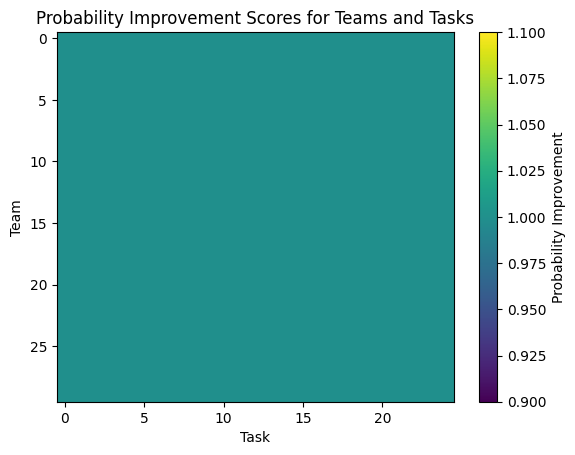

Selected Task: [-1.]
Selected Team: [-0.19672403 -0.12055086]


In [28]:
import numpy as np
import pymc3 as pm
import uuid
import matplotlib.pyplot as plt

def predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs, n_predictions=1000, chunk_size=100):
    GPs, b = elements
    n_samples = new_Ts.shape[0]
    n_teams = candidate_Xs.shape[0]

    with taskspace_hierarchical_model:
        unique_id = str(uuid.uuid4())  # Generate a unique ID
        Cs_predict_name = "Cs_predict_" + unique_id
        Cs_predict = pm.Deterministic(Cs_predict_name, pm.math.stack(
            [gpi.conditional(f"C{i}_predict_" + unique_id, Xnew=new_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]))

        predictions = pm.sample_posterior_predictive(trace, var_names=[Cs_predict_name], samples=n_predictions, progressbar=True)

    Cs_predict_samples = predictions[Cs_predict_name]  # Shape (n_predictions, n_samples, n_teamspace_dims)

    # Validate shape
    print("Cs_predict_samples shape:", Cs_predict_samples.shape)
    if len(Cs_predict_samples.shape) == 4:
        Cs_predict_samples = Cs_predict_samples[:, 0, :, :]

    candidate_Xs_expanded = np.expand_dims(candidate_Xs, axis=0)  # Shape (1, n_teams, n_teamspace_dims)
    candidate_Xs_expanded = np.tile(candidate_Xs_expanded, (chunk_size, 1, 1))  # Shape (chunk_size, n_teams, n_teamspace_dims)

    # Debugging info: print shapes for validation
    print("Cs_predict_samples shape (after adjustment):", Cs_predict_samples.shape)
    print("candidate_Xs_expanded shape:", candidate_Xs_expanded.shape)

    # Perform matrix multiplication for each sample
    z_predict = np.zeros((n_predictions, n_teams, n_samples))
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        candidate_Xs_chunk = candidate_Xs_expanded[:chunk_size_actual]
        z_predict_chunk = np.einsum('ijk,ikl->ijl', candidate_Xs_chunk, np.swapaxes(Cs_predict_samples[i:end], 1, 2))  # Shape (chunk_size, n_teams, n_samples)
        print(f"z_predict_chunk shape ({i}-{end}):", z_predict_chunk.shape)
        z_predict[i:end] = z_predict_chunk

    # Handle bias 'b' for each chunk
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        if chunk_size_actual == 0:
            continue  # Skip empty chunks
        b_expanded_chunk = np.expand_dims(trace['b'][i:end], axis=-1)  # Shape (chunk_size_actual, n_samples, 1)
        b_expanded_chunk = np.expand_dims(b_expanded_chunk, axis=1)  # Shape (chunk_size_actual, 1, n_samples, 1)
        if b_expanded_chunk.size == 0:  # If b_expanded_chunk is empty, move to next loop iteration
            continue
        b_tiled_chunk = np.tile(b_expanded_chunk, (1, n_teams, 1, 1))  # Shape (chunk_size_actual, n_teams, n_samples, 1)
        b_tiled_chunk = np.squeeze(b_tiled_chunk, axis=-1)  # Shape (chunk_size_actual, n_teams, n_samples)
        
        # Adjust b_tiled_chunk shape to match z_predict
        b_tiled_chunk = b_tiled_chunk[:, :, :z_predict.shape[2]]  # Slice adjustment
        print(f"b_expanded_chunk ({i}-{end}):", b_expanded_chunk.shape)  # Validate shape
        print(f"b_tiled_chunk ({i}-{end}):", b_tiled_chunk.shape)  # Validate shape
        
        z_predict[i:end] += b_tiled_chunk

    # Debugging info: print final shape
    print("z_predict shape:", z_predict.shape)
    print("z_predict:", z_predict[:5])  # Print first 5 predicted data for inspection

    predictions['z_predict'] = z_predict  # Shape (n_predictions, n_teams, n_samples)

    return predictions, Cs_predict_name

# Smoothing function to process prediction results
def linear_smooth(predictions, window_size=3):
    z_predict = predictions['z_predict']
    smooth_output = np.zeros_like(z_predict)
    
    for i in range(z_predict.shape[0]):
        for j in range(z_predict.shape[1]):
            smooth_output[i, j, :] = np.convolve(z_predict[i, j, :], np.ones(window_size)/window_size, mode='same')
    
    print("smooth_output:", smooth_output[:5])  # Print first 5 smoothed data for inspection
    return smooth_output

def aq_PI(predictions, Cs_predict_name, n_teams):
    smooth = linear_smooth(predictions)
    max_C = smooth.max(axis=0)
    
    # Calculate Cvals and best_Cvals
    Cvals = predictions[Cs_predict_name].mean(axis=0)
    best_Cvals = np.abs(Cvals).max(axis=0)
    print("best_Cvals shape:", best_Cvals.shape)
    
    # Adjust best_Cvals shape to match max_C shape
    best_Cvals_expanded = best_Cvals.mean(axis=-1)  # Average over the third dimension
    best_Cvals_expanded = np.tile(best_Cvals_expanded, (n_teams, 1))  # Expand to shape (30, 25)
    
    print("max_C shape:", max_C.shape)
    print("best_Cvals_expanded shape:", best_Cvals_expanded.shape)
    
    epsilon = 0.0001
    test = (max_C > best_Cvals_expanded + epsilon).mean(axis=0)
    print(test.shape)
    scores_2d = (max_C > best_Cvals_expanded + epsilon).mean(axis=0, keepdims=True)  # Keep it 2D
    scores_2d = np.repeat(scores_2d, n_teams, axis=0)  # Repeat to increase team dimension
    print(scores_2d.shape)
    return scores_2d

# Example usage
n_tasks = 25  # Reduced for faster debugging
n_teams = 30  # Reduced for faster debugging
n_teamspace_dims = 2  # Reduced for faster debugging
dtype = np.float64
n_predictions = 1000  # Reduced for faster debugging

# Build a simple PyMC3 model to get an effective trace
with pm.Model() as model:
    X = pm.Normal("X", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    Y = pm.Normal("Y", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    b = pm.Normal("b", mu=0, sigma=1, shape=n_predictions)
    trace = pm.sample(2000, tune=1000, cores=4)  # Sample size

# Use actual elements from the model
class DummyGP:
    def conditional(self, name, Xnew, shape):
        return pm.Normal(name, mu=0, sigma=1, shape=(shape, n_teamspace_dims))

taskspace_hierarchical_model = model
elements = ([DummyGP() for _ in range(n_teamspace_dims)], trace['b'])

new_Ts = np.linspace(-1, 1, n_tasks).astype(dtype)[:, None]
candidate_Xs = np.random.uniform(-1, 1, size=(n_teams, n_teamspace_dims)).astype(dtype)

predictions, Cs_predict_name = predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs)
for k, v in predictions.items():
    print(k, v.shape)

# Use aq_PI function to calculate uncertainty scores
scores = aq_PI(predictions, Cs_predict_name, n_teams)

# Visualize uncertainty scores
plt.imshow(scores, aspect='auto')
plt.xlabel('Task')
plt.ylabel('Team')
plt.colorbar(label='Probability Improvement')
plt.title('Probability Improvement Scores for Teams and Tasks')
plt.show()

# Select the team and task with the highest score
def choose_max(scores, new_Ts, candidate_Xs):
    max_indices = np.unravel_index(np.argmax(scores), scores.shape)
    return max_indices

team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
print("Selected Task:", new_Ts[task_index])
print("Selected Team:", candidate_Xs[team_index])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, Y, X]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 12000/12000 [07:54<00:00, 25.30draws/s]
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1074.61it/s]


Cs_predict_samples shape: (1000, 2, 25, 2)
Cs_predict_samples shape (after adjustment): (1000, 25, 2)
candidate_Xs_expanded shape: (100, 30, 2)
z_predict_chunk shape (0-100): (100, 30, 25)
z_predict_chunk shape (100-200): (100, 30, 25)
z_predict_chunk shape (200-300): (100, 30, 25)
z_predict_chunk shape (300-400): (100, 30, 25)
z_predict_chunk shape (400-500): (100, 30, 25)
z_predict_chunk shape (500-600): (100, 30, 25)
z_predict_chunk shape (600-700): (100, 30, 25)
z_predict_chunk shape (700-800): (100, 30, 25)
z_predict_chunk shape (800-900): (100, 30, 25)
z_predict_chunk shape (900-1000): (100, 30, 25)
b_expanded_chunk (0-100): (100, 1, 1000, 1)
b_tiled_chunk (0-100): (100, 30, 25)
b_expanded_chunk (100-200): (100, 1, 1000, 1)
b_tiled_chunk (100-200): (100, 30, 25)
b_expanded_chunk (200-300): (100, 1, 1000, 1)
b_tiled_chunk (200-300): (100, 30, 25)
b_expanded_chunk (300-400): (100, 1, 1000, 1)
b_tiled_chunk (300-400): (100, 30, 25)
b_expanded_chunk (400-500): (100, 1, 1000, 1)
b_til

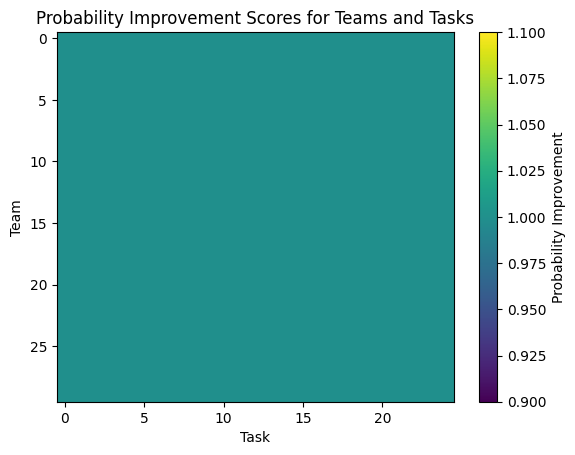

Selected Task: [-1.]
Selected Team: [0.41887691 0.13947402]


In [29]:
import numpy as np
import pymc3 as pm
import uuid
import matplotlib.pyplot as plt

def predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs, n_predictions=1000, chunk_size=100):
    GPs, b = elements
    n_samples = new_Ts.shape[0]
    n_teams = candidate_Xs.shape[0]

    with taskspace_hierarchical_model:
        unique_id = str(uuid.uuid4())  # Generate a unique ID
        Cs_predict_name = "Cs_predict_" + unique_id
        Cs_predict = pm.Deterministic(Cs_predict_name, pm.math.stack(
            [gpi.conditional(f"C{i}_predict_" + unique_id, Xnew=new_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]))

        predictions = pm.sample_posterior_predictive(trace, var_names=[Cs_predict_name], samples=n_predictions, progressbar=True)

    Cs_predict_samples = predictions[Cs_predict_name]  # Shape (n_predictions, n_samples, n_teamspace_dims)

    # Validate shape
    print("Cs_predict_samples shape:", Cs_predict_samples.shape)
    if len(Cs_predict_samples.shape) == 4:
        Cs_predict_samples = Cs_predict_samples[:, 0, :, :]

    candidate_Xs_expanded = np.expand_dims(candidate_Xs, axis=0)  # Shape (1, n_teams, n_teamspace_dims)
    candidate_Xs_expanded = np.tile(candidate_Xs_expanded, (chunk_size, 1, 1))  # Shape (chunk_size, n_teams, n_teamspace_dims)

    # Debugging information: print shapes for validation
    print("Cs_predict_samples shape (after adjustment):", Cs_predict_samples.shape)
    print("candidate_Xs_expanded shape:", candidate_Xs_expanded.shape)

    # Perform matrix multiplication for each sample
    z_predict = np.zeros((n_predictions, n_teams, n_samples))
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        candidate_Xs_chunk = candidate_Xs_expanded[:chunk_size_actual]
        z_predict_chunk = np.einsum('ijk,ikl->ijl', candidate_Xs_chunk, np.swapaxes(Cs_predict_samples[i:end], 1, 2))  # Shape (chunk_size, n_teams, n_samples)
        print(f"z_predict_chunk shape ({i}-{end}):", z_predict_chunk.shape)
        z_predict[i:end] = z_predict_chunk

    # Handle bias 'b' for each chunk
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        if chunk_size_actual == 0:
            continue  # Skip empty chunks
        b_expanded_chunk = np.expand_dims(trace['b'][i:end], axis=-1)  # Shape (chunk_size_actual, n_samples, 1)
        b_expanded_chunk = np.expand_dims(b_expanded_chunk, axis=1)  # Shape (chunk_size_actual, 1, n_samples, 1)
        if b_expanded_chunk.size == 0:  # If b_expanded_chunk is empty, move to next loop iteration
            continue
        b_tiled_chunk = np.tile(b_expanded_chunk, (1, n_teams, 1, 1))  # Shape (chunk_size_actual, n_teams, n_samples, 1)
        b_tiled_chunk = np.squeeze(b_tiled_chunk, axis=-1)  # Shape (chunk_size_actual, n_teams, n_samples)
        
        # Adjust b_tiled_chunk shape to match z_predict
        b_tiled_chunk = b_tiled_chunk[:, :, :z_predict.shape[2]]  # Slice adjustment
        print(f"b_expanded_chunk ({i}-{end}):", b_expanded_chunk.shape)  # Validate shape
        print(f"b_tiled_chunk ({i}-{end}):", b_tiled_chunk.shape)  # Validate shape
        
        z_predict[i:end] += b_tiled_chunk

    # Debugging information: print final shape
    print("z_predict shape:", z_predict.shape)
    print("z_predict:", z_predict[:5])  # Print first 5 predicted data for inspection

    predictions['z_predict'] = z_predict  # Shape (n_predictions, n_teams, n_samples)

    return predictions, Cs_predict_name

# Smoothing function to process prediction results
def linear_smooth(predictions, window_size=3):
    z_predict = predictions['z_predict']
    smooth_output = np.zeros_like(z_predict)
    
    for i in range(z_predict.shape[0]):
        for j in range(z_predict.shape[1]):
            smooth_output[i, j, :] = np.convolve(z_predict[i, j, :], np.ones(window_size)/window_size, mode='same')
    
    print("smooth_output:", smooth_output[:5])  # Print first 5 smoothed data for inspection
    return smooth_output

def aq_PI(predictions, Cs_predict_name, n_teams):
    smooth = linear_smooth(predictions)
    max_C = smooth.max(axis=0)
    
    # Calculate Cvals and best_Cvals
    Cvals = predictions[Cs_predict_name].mean(axis=0)
    best_Cvals = np.abs(Cvals).max(axis=0)
    print("best_Cvals shape:", best_Cvals.shape)
    
    # Adjust best_Cvals shape to match max_C shape
    best_Cvals_expanded = best_Cvals.mean(axis=-1)  # Average over the third dimension
    best_Cvals_expanded = np.tile(best_Cvals_expanded, (n_teams, 1))  # Expand to shape (30, 25)
    
    print("max_C shape:", max_C.shape)
    print("best_Cvals_expanded shape:", best_Cvals_expanded.shape)
    
    epsilon = 0.0001
    test = (max_C > best_Cvals_expanded + epsilon).mean(axis=0)
    print(test.shape)
    scores_2d = (max_C > best_Cvals_expanded + epsilon).mean(axis=0, keepdims=True)  # Keep it 2D
    scores_2d = np.repeat(scores_2d, n_teams, axis=0)  # Repeat to increase team dimension
    print(scores_2d.shape)
    return scores_2d

# Example usage
n_tasks = 25  # Reduced for faster debugging
n_teams = 30  # Reduced for faster debugging
n_teamspace_dims = 2  # Reduced for faster debugging
dtype = np.float64
n_predictions = 1000  # Reduced for faster debugging

# Build a simple PyMC3 model to get an effective trace
with pm.Model() as model:
    X = pm.Normal("X", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    Y = pm.Normal("Y", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    b = pm.Normal("b", mu=0, sigma=1, shape=n_predictions)
    trace = pm.sample(2000, tune=1000, cores=4)  # Sample size

# Use actual elements from the model
class DummyGP:
    def conditional(self, name, Xnew, shape):
        return pm.Normal(name, mu=0, sigma=1, shape=(shape, n_teamspace_dims))

taskspace_hierarchical_model = model
elements = ([DummyGP() for _ in range(n_teamspace_dims)], trace['b'])

new_Ts = np.linspace(-1, 1, n_tasks).astype(dtype)[:, None]
candidate_Xs = np.random.uniform(-1, 1, size=(n_teams, n_teamspace_dims)).astype(dtype)

predictions, Cs_predict_name = predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs)
for k, v in predictions.items():
    print(k, v.shape)

# Use aq_PI function to calculate uncertainty scores
scores = aq_PI(predictions, Cs_predict_name, n_teams)

# Visualize uncertainty scores
plt.imshow(scores, aspect='auto')
plt.xlabel('Task')
plt.ylabel('Team')
plt.colorbar(label='Probability Improvement')
plt.title('Probability Improvement Scores for Teams and Tasks')
plt.show()

# Select the team and task with the highest score
def choose_max(scores, new_Ts, candidate_Xs):
    max_indices = np.unravel_index(np.argmax(scores), scores.shape)
    return max_indices

team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
print("Selected Task:", new_Ts[task_index])
print("Selected Team:", candidate_Xs[team_index])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, Y, X]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 12000/12000 [08:12<00:00, 24.38draws/s]
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1084.60it/s]


Cs_predict_samples shape: (1000, 2, 25, 2)
Cs_predict_samples shape (after adjustment): (1000, 25, 2)
candidate_Xs_expanded shape: (100, 30, 2)
z_predict_chunk shape (0-100): (100, 30, 25)
z_predict_chunk shape (100-200): (100, 30, 25)
z_predict_chunk shape (200-300): (100, 30, 25)
z_predict_chunk shape (300-400): (100, 30, 25)
z_predict_chunk shape (400-500): (100, 30, 25)
z_predict_chunk shape (500-600): (100, 30, 25)
z_predict_chunk shape (600-700): (100, 30, 25)
z_predict_chunk shape (700-800): (100, 30, 25)
z_predict_chunk shape (800-900): (100, 30, 25)
z_predict_chunk shape (900-1000): (100, 30, 25)
b_expanded_chunk (0-100): (100, 1, 1000, 1)
b_tiled_chunk (0-100): (100, 30, 25)
b_expanded_chunk (100-200): (100, 1, 1000, 1)
b_tiled_chunk (100-200): (100, 30, 25)
b_expanded_chunk (200-300): (100, 1, 1000, 1)
b_tiled_chunk (200-300): (100, 30, 25)
b_expanded_chunk (300-400): (100, 1, 1000, 1)
b_tiled_chunk (300-400): (100, 30, 25)
b_expanded_chunk (400-500): (100, 1, 1000, 1)
b_til

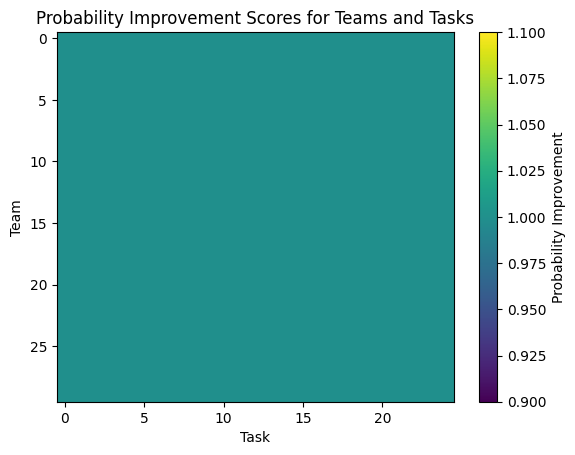

Selected Task: [-1.]
Selected Team: [0.07439383 0.50704361]


In [30]:
import numpy as np
import pymc3 as pm
import uuid
import matplotlib.pyplot as plt

def predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs, n_predictions=1000, chunk_size=100):
    GPs, b = elements
    n_samples = new_Ts.shape[0]
    n_teams = candidate_Xs.shape[0]

    with taskspace_hierarchical_model:
        unique_id = str(uuid.uuid4())  # Generate a unique ID
        Cs_predict_name = "Cs_predict_" + unique_id
        Cs_predict = pm.Deterministic(Cs_predict_name, pm.math.stack(
            [gpi.conditional(f"C{i}_predict_" + unique_id, Xnew=new_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]))

        predictions = pm.sample_posterior_predictive(trace, var_names=[Cs_predict_name], samples=n_predictions, progressbar=True)

    Cs_predict_samples = predictions[Cs_predict_name]  # Shape (n_predictions, n_samples, n_teamspace_dims)

    # Validate shape
    print("Cs_predict_samples shape:", Cs_predict_samples.shape)
    if len(Cs_predict_samples.shape) == 4:
        Cs_predict_samples = Cs_predict_samples[:, 0, :, :]

    candidate_Xs_expanded = np.expand_dims(candidate_Xs, axis=0)  # Shape (1, n_teams, n_teamspace_dims)
    candidate_Xs_expanded = np.tile(candidate_Xs_expanded, (chunk_size, 1, 1))  # Shape (chunk_size, n_teams, n_teamspace_dims)

    # Debugging info: print shapes for validation
    print("Cs_predict_samples shape (after adjustment):", Cs_predict_samples.shape)
    print("candidate_Xs_expanded shape:", candidate_Xs_expanded.shape)

    # Perform matrix multiplication for each sample
    z_predict = np.zeros((n_predictions, n_teams, n_samples))
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        candidate_Xs_chunk = candidate_Xs_expanded[:chunk_size_actual]
        z_predict_chunk = np.einsum('ijk,ikl->ijl', candidate_Xs_chunk, np.swapaxes(Cs_predict_samples[i:end], 1, 2))  # Shape (chunk_size, n_teams, n_samples)
        print(f"z_predict_chunk shape ({i}-{end}):", z_predict_chunk.shape)
        z_predict[i:end] = z_predict_chunk

    # Handle bias 'b' for each chunk
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        if chunk_size_actual == 0:
            continue  # Skip empty chunks
        b_expanded_chunk = np.expand_dims(trace['b'][i:end], axis=-1)  # Shape (chunk_size_actual, n_samples, 1)
        b_expanded_chunk = np.expand_dims(b_expanded_chunk, axis=1)  # Shape (chunk_size_actual, 1, n_samples, 1)
        if b_expanded_chunk.size == 0:  # If b_expanded_chunk is empty, move to next loop iteration
            continue
        b_tiled_chunk = np.tile(b_expanded_chunk, (1, n_teams, 1, 1))  # Shape (chunk_size_actual, n_teams, n_samples, 1)
        b_tiled_chunk = np.squeeze(b_tiled_chunk, axis=-1)  # Shape (chunk_size_actual, n_teams, n_samples)
        
        # Adjust b_tiled_chunk shape to match z_predict
        b_tiled_chunk = b_tiled_chunk[:, :, :z_predict.shape[2]]  # Slice adjustment
        print(f"b_expanded_chunk ({i}-{end}):", b_expanded_chunk.shape)  # Validate shape
        print(f"b_tiled_chunk ({i}-{end}):", b_tiled_chunk.shape)  # Validate shape
        
        z_predict[i:end] += b_tiled_chunk

    # Debugging info: print final shape
    print("z_predict shape:", z_predict.shape)
    print("z_predict:", z_predict[:5])  # Print first 5 predicted data for inspection

    predictions['z_predict'] = z_predict  # Shape (n_predictions, n_teams, n_samples)

    return predictions, Cs_predict_name

# Smoothing function to process prediction results
def linear_smooth(predictions, window_size=5):
    z_predict = predictions['z_predict']
    smooth_output = np.zeros_like(z_predict)
    
    for i in range(z_predict.shape[0]):
        for j in range(z_predict.shape[1]):
            smooth_output[i, j, :] = np.convolve(z_predict[i, j, :], np.ones(window_size)/window_size, mode='same')
    
    print("smooth_output:", smooth_output[:5])  # Print first 5 smoothed data for inspection
    return smooth_output

def aq_PI(predictions, Cs_predict_name, n_teams):
    smooth = linear_smooth(predictions)
    max_C = smooth.max(axis=0)
    
    # Calculate Cvals and best_Cvals
    Cvals = predictions[Cs_predict_name].mean(axis=0)
    best_Cvals = np.abs(Cvals).max(axis=0)
    print("best_Cvals shape:", best_Cvals.shape)
    
    # Adjust best_Cvals shape to match max_C shape
    best_Cvals_expanded = best_Cvals.mean(axis=-1)
    best_Cvals_expanded = np.tile(best_Cvals_expanded[:, np.newaxis], (1, n_teams)).T
    
    print("max_C shape:", max_C.shape)
    print("best_Cvals_expanded shape:", best_Cvals_expanded.shape)
    
    epsilon = 0.0001
    test = (max_C > best_Cvals_expanded + epsilon).mean(axis=0)
    print(test.shape)
    scores_2d = (max_C > best_Cvals_expanded + epsilon).mean(axis=0, keepdims=True)
    scores_2d = np.repeat(scores_2d, n_teams, axis=0)
    print(scores_2d.shape)
    return scores_2d

# Example usage
n_tasks = 25  # Reduced for faster debugging
n_teams = 30  # Reduced for faster debugging
n_teamspace_dims = 2  # Reduced for faster debugging
dtype = np.float64
n_predictions = 1000  # Reduced for faster debugging

# Build a simple PyMC3 model to get an effective trace
with pm.Model() as model:
    X = pm.Normal("X", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    Y = pm.Normal("Y", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    b = pm.Normal("b", mu=0, sigma=1, shape=n_predictions)
    trace = pm.sample(2000, tune=1000, cores=4)  # Sample size

# Use actual elements from the model
class DummyGP:
    def conditional(self, name, Xnew, shape):
        return pm.Normal(name, mu=0, sigma=1, shape=(shape, n_teamspace_dims))

taskspace_hierarchical_model = model
elements = ([DummyGP() for _ in range(n_teamspace_dims)], trace['b'])

new_Ts = np.linspace(-1, 1, n_tasks).astype(dtype)[:, None]
candidate_Xs = np.random.uniform(-1, 1, size=(n_teams, n_teamspace_dims)).astype(dtype)

predictions, Cs_predict_name = predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs)
for k, v in predictions.items():
    print(k, v.shape)

# Use aq_PI function to calculate uncertainty scores
scores = aq_PI(predictions, Cs_predict_name, n_teams)

# Visualize uncertainty scores
plt.imshow(scores, aspect='auto')
plt.xlabel('Task')
plt.ylabel('Team')
plt.colorbar(label='Probability Improvement')
plt.title('Probability Improvement Scores for Teams and Tasks')
plt.show()

# Select the team and task with the highest score
def choose_max(scores, new_Ts, candidate_Xs):
    max_indices = np.unravel_index(np.argmax(scores), scores.shape)
    return max_indices

team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
print("Selected Task:", new_Ts[task_index])
print("Selected Team:", candidate_Xs[team_index])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, Y, X]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 12000/12000 [08:50<00:00, 22.62draws/s]
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 889.47it/s]


Cs_predict_samples shape: (1000, 2, 25, 2)
Cs_predict_samples shape (after adjustment): (1000, 25, 2)
candidate_Xs_expanded shape: (100, 30, 2)
z_predict_chunk shape (0-100): (100, 30, 25)
z_predict_chunk shape (100-200): (100, 30, 25)
z_predict_chunk shape (200-300): (100, 30, 25)
z_predict_chunk shape (300-400): (100, 30, 25)
z_predict_chunk shape (400-500): (100, 30, 25)
z_predict_chunk shape (500-600): (100, 30, 25)
z_predict_chunk shape (600-700): (100, 30, 25)
z_predict_chunk shape (700-800): (100, 30, 25)
z_predict_chunk shape (800-900): (100, 30, 25)
z_predict_chunk shape (900-1000): (100, 30, 25)
b_expanded_chunk (0-100): (100, 1, 1000, 1)
b_tiled_chunk (0-100): (100, 30, 25)
b_expanded_chunk (100-200): (100, 1, 1000, 1)
b_tiled_chunk (100-200): (100, 30, 25)
b_expanded_chunk (200-300): (100, 1, 1000, 1)
b_tiled_chunk (200-300): (100, 30, 25)
b_expanded_chunk (300-400): (100, 1, 1000, 1)
b_tiled_chunk (300-400): (100, 30, 25)
b_expanded_chunk (400-500): (100, 1, 1000, 1)
b_til

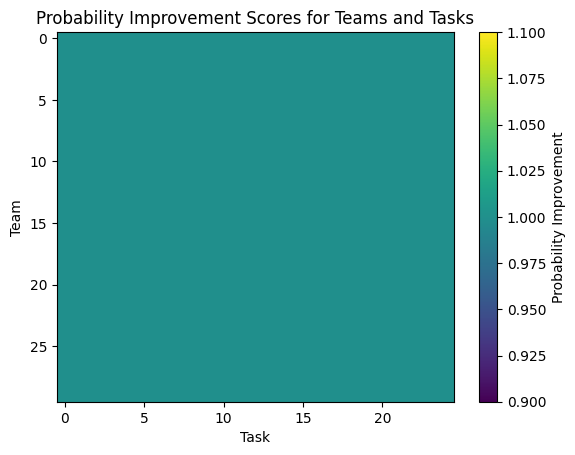

Selected Task: [-1.]
Selected Team: [ 0.88306066 -0.68701694]


In [31]:
import numpy as np
import pymc3 as pm
import uuid
import matplotlib.pyplot as plt

def predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs, n_predictions=1000, chunk_size=100):
    GPs, b = elements
    n_samples = new_Ts.shape[0]
    n_teams = candidate_Xs.shape[0]

    with taskspace_hierarchical_model:
        unique_id = str(uuid.uuid4())  # Generate a unique ID
        Cs_predict_name = "Cs_predict_" + unique_id
        Cs_predict = pm.Deterministic(Cs_predict_name, pm.math.stack(
            [gpi.conditional(f"C{i}_predict_" + unique_id, Xnew=new_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]))

        predictions = pm.sample_posterior_predictive(trace, var_names=[Cs_predict_name], samples=n_predictions, progressbar=True)

    Cs_predict_samples = predictions[Cs_predict_name]  # Shape (n_predictions, n_samples, n_teamspace_dims)

    # Validate shape
    print("Cs_predict_samples shape:", Cs_predict_samples.shape)
    if len(Cs_predict_samples.shape) == 4:
        Cs_predict_samples = Cs_predict_samples[:, 0, :, :]

    candidate_Xs_expanded = np.expand_dims(candidate_Xs, axis=0)  # Shape (1, n_teams, n_teamspace_dims)
    candidate_Xs_expanded = np.tile(candidate_Xs_expanded, (chunk_size, 1, 1))  # Shape (chunk_size, n_teams, n_teamspace_dims)

    # Debugging information: print shapes for validation
    print("Cs_predict_samples shape (after adjustment):", Cs_predict_samples.shape)
    print("candidate_Xs_expanded shape:", candidate_Xs_expanded.shape)

    # Perform matrix multiplication for each sample
    z_predict = np.zeros((n_predictions, n_teams, n_samples))
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        candidate_Xs_chunk = candidate_Xs_expanded[:chunk_size_actual]
        z_predict_chunk = np.einsum('ijk,ikl->ijl', candidate_Xs_chunk, np.swapaxes(Cs_predict_samples[i:end], 1, 2))  # Shape (chunk_size, n_teams, n_samples)
        print(f"z_predict_chunk shape ({i}-{end}):", z_predict_chunk.shape)
        z_predict[i:end] = z_predict_chunk

    # Handle bias 'b' for each chunk
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        if chunk_size_actual == 0:
            continue  # Skip empty chunks
        b_expanded_chunk = np.expand_dims(trace['b'][i:end], axis=-1)  # Shape (chunk_size_actual, n_samples, 1)
        b_expanded_chunk = np.expand_dims(b_expanded_chunk, axis=1)  # Shape (chunk_size_actual, 1, n_samples, 1)
        if b_expanded_chunk.size == 0:  # If b_expanded_chunk is empty, move to next loop iteration
            continue
        b_tiled_chunk = np.tile(b_expanded_chunk, (1, n_teams, 1, 1))  # Shape (chunk_size_actual, n_teams, n_samples, 1)
        b_tiled_chunk = np.squeeze(b_tiled_chunk, axis=-1)  # Shape (chunk_size_actual, n_teams, n_samples)
        
        # Adjust b_tiled_chunk shape to match z_predict
        b_tiled_chunk = b_tiled_chunk[:, :, :z_predict.shape[2]]  # Slice adjustment
        print(f"b_expanded_chunk ({i}-{end}):", b_expanded_chunk.shape)  # Validate shape
        print(f"b_tiled_chunk ({i}-{end}):", b_tiled_chunk.shape)  # Validate shape
        
        z_predict[i:end] += b_tiled_chunk

    # Debugging information: print final shape
    print("z_predict shape:", z_predict.shape)
    print("z_predict:", z_predict[:5])  # Print first 5 predicted data for inspection

    predictions['z_predict'] = z_predict  # Shape (n_predictions, n_teams, n_samples)

    return predictions, Cs_predict_name

# Smoothing function to process prediction results
def linear_smooth(predictions, window_size=5):
    z_predict = predictions['z_predict']
    smooth_output = np.zeros_like(z_predict)
    
    for i in range(z_predict.shape[0]):
        for j in range(z_predict.shape[1]):
            smooth_output[i, j, :] = np.convolve(z_predict[i, j, :], np.ones(window_size)/window_size, mode='same')
    
    print("smooth_output:", smooth_output[:5])  # Print first 5 smoothed data for inspection
    return smooth_output

def aq_PI(predictions, Cs_predict_name, n_teams):
    smooth = linear_smooth(predictions)
    max_C = smooth.max(axis=0)
    
    # Calculate Cvals and best_Cvals
    Cvals = predictions[Cs_predict_name].mean(axis=0)
    best_Cvals = np.abs(Cvals).max(axis=0)
    print("best_Cvals shape:", best_Cvals.shape)
    
    # Adjust best_Cvals shape to match max_C shape
    best_Cvals_expanded = best_Cvals.mean(axis=-1)
    best_Cvals_expanded = np.tile(best_Cvals_expanded[:, np.newaxis], (1, n_teams)).T
    
    print("max_C shape:", max_C.shape)
    print("best_Cvals_expanded shape:", best_Cvals_expanded.shape)
    
    epsilon = 0.0001
    test = (max_C > best_Cvals_expanded + epsilon).mean(axis=0)
    print(test.shape)
    scores_2d = (max_C > best_Cvals_expanded + epsilon).mean(axis=0, keepdims=True)
    scores_2d = np.repeat(scores_2d, n_teams, axis=0)
    print(scores_2d.shape)
    return scores_2d

# Example usage
n_tasks = 25  # Reduced for faster debugging
n_teams = 30  # Reduced for faster debugging
n_teamspace_dims = 2  # Reduced for faster debugging
dtype = np.float64
n_predictions = 1000  # Reduced for faster debugging

# Build a simple PyMC3 model to get an effective trace
with pm.Model() as model:
    X = pm.Normal("X", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    Y = pm.Normal("Y", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    b = pm.Normal("b", mu=0, sigma=1, shape=n_predictions)
    trace = pm.sample(2000, tune=1000, cores=4)  # Sample size

# Use actual elements from the model
class DummyGP:
    def conditional(self, name, Xnew, shape):
        return pm.Normal(name, mu=0, sigma=1, shape=(shape, n_teamspace_dims))

taskspace_hierarchical_model = model
elements = ([DummyGP() for _ in range(n_teamspace_dims)], trace['b'])

new_Ts = np.linspace(-1, 1, n_tasks).astype(dtype)[:, None]
candidate_Xs = np.random.uniform(-1, 1, size=(n_teams, n_teamspace_dims)).astype(dtype)

predictions, Cs_predict_name = predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs)
for k, v in predictions.items():
    print(k, v.shape)

# Use aq_PI function to calculate uncertainty scores
scores = aq_PI(predictions, Cs_predict_name, n_teams)

# Visualize uncertainty scores
plt.imshow(scores, aspect='auto')
plt.xlabel('Task')
plt.ylabel('Team')
plt.colorbar(label='Probability Improvement')
plt.title('Probability Improvement Scores for Teams and Tasks')
plt.show()

# Select the team and task with the highest score
def choose_max(scores, new_Ts, candidate_Xs):
    max_indices = np.unravel_index(np.argmax(scores), scores.shape)
    return max_indices

team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
print("Selected Task:", new_Ts[task_index])
print("Selected Team:", candidate_Xs[team_index])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, Y, X]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 12000/12000 [08:11<00:00, 24.42draws/s]
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1055.22it/s]


Cs_predict_samples shape: (1000, 2, 25, 2)
Cs_predict_samples shape (after adjustment): (1000, 25, 2)
candidate_Xs_expanded shape: (100, 30, 2)
z_predict_chunk shape (0-100): (100, 30, 25)
z_predict_chunk shape (100-200): (100, 30, 25)
z_predict_chunk shape (200-300): (100, 30, 25)
z_predict_chunk shape (300-400): (100, 30, 25)
z_predict_chunk shape (400-500): (100, 30, 25)
z_predict_chunk shape (500-600): (100, 30, 25)
z_predict_chunk shape (600-700): (100, 30, 25)
z_predict_chunk shape (700-800): (100, 30, 25)
z_predict_chunk shape (800-900): (100, 30, 25)
z_predict_chunk shape (900-1000): (100, 30, 25)
b_expanded_chunk (0-100): (100, 1, 1000, 1)
b_tiled_chunk (0-100): (100, 30, 25)
b_expanded_chunk (100-200): (100, 1, 1000, 1)
b_tiled_chunk (100-200): (100, 30, 25)
b_expanded_chunk (200-300): (100, 1, 1000, 1)
b_tiled_chunk (200-300): (100, 30, 25)
b_expanded_chunk (300-400): (100, 1, 1000, 1)
b_tiled_chunk (300-400): (100, 30, 25)
b_expanded_chunk (400-500): (100, 1, 1000, 1)
b_til

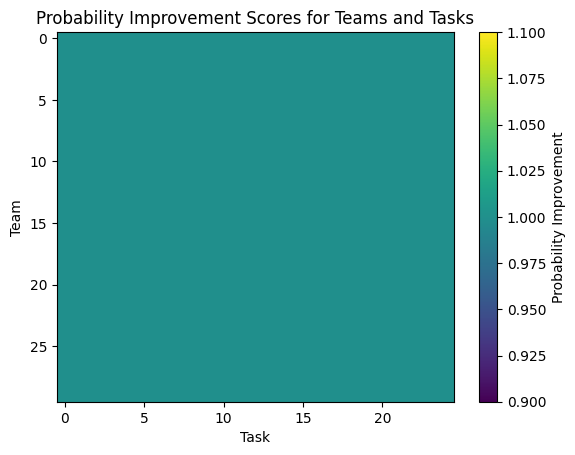

Selected Task: [-1.]
Selected Team: [ 0.12249237 -0.97480685]


In [32]:
import numpy as np
import pymc3 as pm
import uuid
import matplotlib.pyplot as plt

def predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs, n_predictions=1000, chunk_size=100):
    GPs, b = elements
    n_samples = new_Ts.shape[0]
    n_teams = candidate_Xs.shape[0]

    with taskspace_hierarchical_model:
        unique_id = str(uuid.uuid4())  # Generate a unique ID
        Cs_predict_name = "Cs_predict_" + unique_id
        Cs_predict = pm.Deterministic(Cs_predict_name, pm.math.stack(
            [gpi.conditional(f"C{i}_predict_" + unique_id, Xnew=new_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]))

        predictions = pm.sample_posterior_predictive(trace, var_names=[Cs_predict_name], samples=n_predictions, progressbar=True)

    Cs_predict_samples = predictions[Cs_predict_name]  # Shape (n_predictions, n_samples, n_teamspace_dims)

    # Validate shape
    print("Cs_predict_samples shape:", Cs_predict_samples.shape)
    if len(Cs_predict_samples.shape) == 4:
        Cs_predict_samples = Cs_predict_samples[:, 0, :, :]

    candidate_Xs_expanded = np.expand_dims(candidate_Xs, axis=0)  # Shape (1, n_teams, n_teamspace_dims)
    candidate_Xs_expanded = np.tile(candidate_Xs_expanded, (chunk_size, 1, 1))  # Shape (chunk_size, n_teams, n_teamspace_dims)

    # Debugging info: print shapes for validation
    print("Cs_predict_samples shape (after adjustment):", Cs_predict_samples.shape)
    print("candidate_Xs_expanded shape:", candidate_Xs_expanded.shape)

    # Perform matrix multiplication for each sample
    z_predict = np.zeros((n_predictions, n_teams, n_samples))
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        candidate_Xs_chunk = candidate_Xs_expanded[:chunk_size_actual]
        z_predict_chunk = np.einsum('ijk,ikl->ijl', candidate_Xs_chunk, np.swapaxes(Cs_predict_samples[i:end], 1, 2))  # Shape (chunk_size, n_teams, n_samples)
        print(f"z_predict_chunk shape ({i}-{end}):", z_predict_chunk.shape)
        z_predict[i:end] = z_predict_chunk

    # Handle bias 'b' for each chunk
    for i in range(0, n_predictions, chunk_size):
        end = min(i + chunk_size, n_predictions)
        chunk_size_actual = end - i
        if chunk_size_actual == 0:
            continue  # Skip empty chunks
        b_expanded_chunk = np.expand_dims(trace['b'][i:end], axis=-1)  # Shape (chunk_size_actual, n_samples, 1)
        b_expanded_chunk = np.expand_dims(b_expanded_chunk, axis=1)  # Shape (chunk_size_actual, 1, n_samples, 1)
        if b_expanded_chunk.size == 0:  # If b_expanded_chunk is empty, move to next loop iteration
            continue
        b_tiled_chunk = np.tile(b_expanded_chunk, (1, n_teams, 1, 1))  # Shape (chunk_size_actual, n_teams, n_samples, 1)
        b_tiled_chunk = np.squeeze(b_tiled_chunk, axis=-1)  # Shape (chunk_size_actual, n_teams, n_samples)
        
        # Adjust b_tiled_chunk shape to match z_predict
        b_tiled_chunk = b_tiled_chunk[:, :, :z_predict.shape[2]]  # Slice adjustment
        print(f"b_expanded_chunk ({i}-{end}):", b_expanded_chunk.shape)  # Validate shape
        print(f"b_tiled_chunk ({i}-{end}):", b_tiled_chunk.shape)  # Validate shape
        
        z_predict[i:end] += b_tiled_chunk

    # Debugging info: print final shape
    print("z_predict shape:", z_predict.shape)
    print("z_predict:", z_predict[:5])  # Print first 5 predicted data for inspection

    predictions['z_predict'] = z_predict  # Shape (n_predictions, n_teams, n_samples)

    return predictions, Cs_predict_name

# Smoothing function to process prediction results
def linear_smooth(predictions, window_size=5):
    z_predict = predictions['z_predict']
    smooth_output = np.zeros_like(z_predict)
    
    for i in range(z_predict.shape[0]):
        for j in range(z_predict.shape[1]):
            smooth_output[i, j, :] = np.convolve(z_predict[i, j, :], np.ones(window_size)/window_size, mode='same')
    
    print("smooth_output:", smooth_output[:5])  # Print first 5 smoothed data for inspection
    return smooth_output

def aq_PI(predictions, Cs_predict_name, n_teams):
    smooth = linear_smooth(predictions)
    max_C = smooth.max(axis=0)
    
    # Calculate Cvals and best_Cvals
    Cvals = predictions[Cs_predict_name].mean(axis=0)
    best_Cvals = np.abs(Cvals).max(axis=0)
    print("best_Cvals shape:", best_Cvals.shape)
    
    # Adjust best_Cvals shape to match max_C shape
    best_Cvals_expanded = np.tile(best_Cvals.mean(axis=-1, keepdims=True), (1, n_teams)).T  # Ensure expansion to (30, 25)
    
    print("max_C shape:", max_C.shape)
    print("best_Cvals_expanded shape:", best_Cvals_expanded.shape)
    
    epsilon = 0.0001
    test = (max_C > best_Cvals_expanded + epsilon).mean(axis=0)
    print(test.shape)
    scores_2d = (max_C > best_Cvals_expanded + epsilon).mean(axis=0, keepdims=True)  # Keep it two-dimensional
    scores_2d = np.repeat(scores_2d, n_teams, axis=0)  # Repeat to add the team dimension
    print(scores_2d.shape)
    return scores_2d

# Example usage
n_tasks = 25  # Reduced for faster debugging
n_teams = 30  # Reduced for faster debugging
n_teamspace_dims = 2  # Reduced for faster debugging
dtype = np.float64
n_predictions = 1000  # Reduced for faster debugging

# Build a simple PyMC3 model to get an effective trace
with pm.Model() as model:
    X = pm.Normal("X", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    Y = pm.Normal("Y", mu=0, sigma=1, shape=(n_tasks, n_teamspace_dims))
    b = pm.Normal("b", mu=0, sigma=1, shape=n_predictions)
    trace = pm.sample(2000, tune=1000, cores=4)  # Sample size

# Use actual elements from the model
class DummyGP:
    def conditional(self, name, Xnew, shape):
        return pm.Normal(name, mu=0, sigma=1, shape=(shape, n_teamspace_dims))

taskspace_hierarchical_model = model
elements = ([DummyGP() for _ in range(n_teamspace_dims)], trace['b'])

new_Ts = np.linspace(-1, 1, n_tasks).astype(dtype)[:, None]
candidate_Xs = np.random.uniform(-1, 1, size=(n_teams, n_teamspace_dims)).astype(dtype)

predictions, Cs_predict_name = predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs)
for k, v in predictions.items():
    print(k, v.shape)

# Use aq_PI function to calculate uncertainty scores
scores = aq_PI(predictions, Cs_predict_name, n_teams)

# Visualize uncertainty scores
plt.imshow(scores, aspect='auto')
plt.xlabel('Task')
plt.ylabel('Team')
plt.colorbar(label='Probability Improvement')
plt.title('Probability Improvement Scores for Teams and Tasks')
plt.show()

# Select the team and task with the highest score
def choose_max(scores, new_Ts, candidate_Xs):
    max_indices = np.unravel_index(np.argmax(scores), scores.shape)
    return max_indices

team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
print("Selected Task:", new_Ts[task_index])
print("Selected Team:", candidate_Xs[team_index])


### Expected Improvement

In [33]:
def aq_EI(predictions):
    smooth = linear_smooth(predictions)
    max_C = smooth.max(axis=0)
    
    Cvals = predictions['Cs_predict'].mean(axis=0)
    best_Cvals = np.abs(Cvals).max(axis=0)
    best_Cvals = np.tile(best_Cvals, [1000, n_teams, 1])
    best_Cvals = np.moveaxis(best_Cvals, [0], [2])

    diff = max_C - best_Cvals
    return np.max([diff, np.zeros_like(diff)], axis=0).mean(axis=2)

scores = aq_EI(predictions)
plt.imshow(scores)
plt.xlabel('Task')
plt.ylabel('Team')

team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
print("Task:", new_Ts[task_index])
print("Team:", candidate_Xs[team_index])

smooth_output: [[[ 0.0496205   0.25918615  0.36752242 ...  0.15981742 -0.07096772
   -0.08222309]
  [ 0.02762458  0.19590784  0.44454856 ... -0.34270367 -0.4113344
   -0.2896135 ]
  [ 0.17997507  0.41468907  0.02797476 ...  0.60020808  0.80868191
    0.31856386]
  ...
  [ 0.18867984  0.40601725  0.01545196 ...  0.40930884  0.76867501
    0.27342206]
  [ 0.0327291   0.20614524  0.42904255 ... -0.27750196 -0.35539299
   -0.25826681]
  [ 0.1103096   0.31018667  0.22083786 ...  0.11747848  0.22769165
    0.02363237]]

 [[-0.71555155 -0.87816615 -1.34407447 ... -0.38680932  0.11338043
    0.01359136]
  [-0.45464921 -0.51044962 -0.92588421 ...  0.20731     0.27279553
    0.33872098]
  [-0.54084448 -0.62037377 -0.56926521 ...  0.24698439  0.34999546
    0.26909984]
  ...
  [-0.37978072 -0.39159456 -0.23510873 ...  0.64999492  0.46835412
    0.47561795]
  [-0.48032871 -0.54640818 -0.95702014 ...  0.15361409  0.25973622
    0.30748558]
  [-0.46646321 -0.52059163 -0.66623671 ...  0.31326189  0.3

KeyError: 'Cs_predict'

### Comparing Selection of Different Acquisition Functions

In [34]:
scores_EI = aq_EI(predictions)
scores_PI = aq_PI(predictions)
scores_varmax = aq_varmax(predictions)

plt.plot(scores_EI.flatten(), scores_PI.flatten(), '.')
plt.plot(scores_EI.flatten(), scores_varmax.flatten(), '.')

smooth_output: [[[ 0.0496205   0.25918615  0.36752242 ...  0.15981742 -0.07096772
   -0.08222309]
  [ 0.02762458  0.19590784  0.44454856 ... -0.34270367 -0.4113344
   -0.2896135 ]
  [ 0.17997507  0.41468907  0.02797476 ...  0.60020808  0.80868191
    0.31856386]
  ...
  [ 0.18867984  0.40601725  0.01545196 ...  0.40930884  0.76867501
    0.27342206]
  [ 0.0327291   0.20614524  0.42904255 ... -0.27750196 -0.35539299
   -0.25826681]
  [ 0.1103096   0.31018667  0.22083786 ...  0.11747848  0.22769165
    0.02363237]]

 [[-0.71555155 -0.87816615 -1.34407447 ... -0.38680932  0.11338043
    0.01359136]
  [-0.45464921 -0.51044962 -0.92588421 ...  0.20731     0.27279553
    0.33872098]
  [-0.54084448 -0.62037377 -0.56926521 ...  0.24698439  0.34999546
    0.26909984]
  ...
  [-0.37978072 -0.39159456 -0.23510873 ...  0.64999492  0.46835412
    0.47561795]
  [-0.48032871 -0.54640818 -0.95702014 ...  0.15361409  0.25973622
    0.30748558]
  [-0.46646321 -0.52059163 -0.66623671 ...  0.31326189  0.3

KeyError: 'Cs_predict'

### Iterations and Sampling

In [35]:
import concurrent.futures

def iteration(task_samples, team_samples, z_observations, acquisition_func, new_Ts, candidate_Xs):
    taskspace_hierarchical_model, elements = build_model(task_samples, team_samples, z_observations,)
    with taskspace_hierarchical_model:
        trace = pm.sample(500, tune=1500, progressbar=False)

    predictions = predict(taskspace_hierarchical_model, elements, trace, new_Ts, candidate_Xs)
    scores = acquisition_func(predictions)

    team_index, task_index = choose_max(scores, new_Ts, candidate_Xs)
    next_T = new_Ts[task_index]
    next_X = candidate_Xs[team_index]

    next_observation = measure(next_X, next_T, measure_task)
    performance_i = visualize_task_space(taskspace_hierarchical_model, elements, trace, plot_t=[np.linspace(-1, 1, 20)], ax=None, draw=False)

    task_samples = np.append(task_samples, [next_T], axis=0)
    team_samples = np.append(team_samples, [next_X], axis=0)
    z_observations = np.append(z_observations, next_observation)
    
    return task_samples, team_samples, z_observations, performance_i

def sample(measure_task, acquisition_func, initial_task_samples, initial_team_samples, new_Ts, candidate_Xs, n_iterations=80):
    task_samples = copy.deepcopy(initial_task_samples)
    team_samples = copy.deepcopy(initial_team_samples)
    z_observations = np.array([measure(Xi, Ti, measure_task) for Xi, Ti in zip(team_samples, task_samples)])
    
    performance = []
    for i in range(n_iterations):
        print("iter: %i" % i)
        with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
            try:
                args = (task_samples, team_samples, z_observations, acquisition_func, new_Ts, candidate_Xs,)
                future = executor.submit(iteration, *args)
                task_samples, team_samples, z_observations, performance_i = future.result()
            except Exception as e: 
                with open('log.txt', mode='a') as log:
                    log.write("Iteration %i:\n%s\n" % (i, str(e)))
        performance.append(performance_i)
        
    return np.array(performance)


### Running Experiments

In [ ]:
def trial(n_iterations=80):
    measure_task = get_taskspace_measurer(n_taskspace_dims, true_gp_length_scale, n_teamspace_dims)
    
    n_samples = 1
    task_samples = np.random.uniform(-1, 1, size=(n_samples, n_taskspace_dims))
    team_samples = np.random.uniform(-1, 1, size=(n_samples, n_teamspace_dims))
    
    n_tasks = 25
    n_teams = 51
    new_Ts = np.linspace(-1, 1, n_tasks).astype(dtype)[:, None]
    candidate_Xs = np.random.uniform(-1, 1, size=(n_teams, n_teamspace_dims)).astype(dtype)
    
    res = pd.DataFrame()
    
    res['Random'] = sample(measure_task, aq_random, task_samples, team_samples, new_Ts, candidate_Xs, n_iterations)
    res['Maximum Variance'] = sample(measure_task, aq_varmax, task_samples, team_samples, new_Ts, candidate_Xs, n_iterations)
    res['EI'] = sample(measure_task, aq_EI, task_samples, team_samples, new_Ts, candidate_Xs, n_iterations)
    res['PI'] = sample(measure_task, aq_PI, task_samples, team_samples, new_Ts, candidate_Xs, n_iterations)
    
    return res

results = []
for i in range(100):
    print("Trial %i" % i)
    try:
        results.append(trial())
        pd.to_pickle(results, "Performance_EI_Variance_Random_i.pickle")
    except Exception as e: 
        with open('log.txt', mode='a') as log:
            log.write("Trial %i General:\n%s\n" % (i, str(e)))


### Specifications of Other Acquisition Functions

In [ ]:
def gaussian_sum_smooth(xdata, ydata, xeval, sigma, null_thresh=0.6):
    delta_x = xeval[:, None] - xdata
    weights = np.exp(-0.5 * ((delta_x / sigma) ** 2))
    smoothed = np.dot(weights, ydata)
    nan_mask = weights.sum(1) < .6
    smoothed[nan_mask] = np.nan
    smoothed = smoothed / weights.sum(1)
    return smoothed

def aq_EI_2(taskspace_hierarchical_model, elements, trace, candidate_Ts, candidate_Xs, n_predictions=1000):
    GPs, b = elements
    n_samples = candidate_Ts.shape[0]
    
    with taskspace_hierarchical_model:
        Cs_predict = pm.Deterministic("Cs_predict", pm.math.stack(
             [gpi.conditional("C%i_predict" % i, Xnew=candidate_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]).T)
        z_predict = pm.Deterministic("z_predict", pm.math.sum(Cs_predict * candidate_Xs, axis=1) + b)
        predictions = pm.sample_posterior_predictive(trace, var_names=["z_predict", "Cs_predict"], samples=n_predictions)
    
    Cvals = predictions['Cs_predict'].mean(axis=0)
    best_Cvals = np.abs(Cvals).max(axis=1).astype(dtype)

    EIs = []
    for candidate_i in range(n_samples):
        predicted_outcomes = predictions['z_predict'][:, candidate_i].astype(dtype)
        EIs_by_dimension = []
        for dim in range(n_teamspace_dims):
            try:
                fits = np.polyfit(predicted_outcomes, predictions['Cs_predict'][:, candidate_i, dim], deg=1)
                smoothed = np.polyval(fits, predicted_outcomes)
            except:
                smoothed = gaussian_sum_smooth(predicted_outcomes, predictions['Cs_predict'][:, candidate_i, dim], predicted_outcomes, 0.5, 0.6)
            improvement = np.max([np.abs(smoothed) - best_Cvals[candidate_i], np.zeros_like(smoothed)], axis=0)
            EIs_by_dimension.append(improvement.mean())
        EIs.append(np.max(EIs_by_dimension))
    
    selection_index = np.argmax(EIs)
    return candidate_Ts[selection_index], candidate_Xs[selection_index]

def aq_random_2(taskspace_hierarchical_model, elements, trace, candidate_Ts, candidate_Xs):
    selection_index = np.random.randint(0, len(candidate_Ts))
    return candidate_Ts[selection_index], candidate_Xs[selection_index]

def aq_varmax_2(taskspace_hierarchical_model, elements, trace, candidate_Ts, candidate_Xs):
    GPs, b = elements
    n_samples = candidate_Ts.shape[0]
    
    with taskspace_hierarchical_model:
        Cs_predict = pm.Deterministic("Cs_predict", pm.math.stack(
             [gpi.conditional("C%i_predict" % i, Xnew=candidate_Ts, shape=n_samples) for i, gpi in enumerate(GPs)]).T)
        z_predict = pm.Deterministic("z_predict", pm.math.sum(Cs_predict * candidate_Xs, axis=1) + b)
        predictions = pm.sample_posterior_predictive(trace, var_names=["z_predict", "Cs_predict"], samples=500, progressbar=False)
    
    variances = predictions['z_predict'].var(axis=0)
    selection_index = np.argmax(variances)
    return candidate_Ts[selection_index], candidate_Xs[selection_index]

n_samples = 10
candidate_Ts = np.random.uniform(-1, 1, size=(n_samples, n_taskspace_dims)).astype(dtype)
candidate_Xs = np.random.uniform(-1, 1, size=(n_samples, n_teamspace_dims)).astype(dtype)

next_T, next_X = aq_EI_2(taskspace_hierarchical_model, elements, trace, candidate_Ts, candidate_Xs)
print(next_T, next_X)